In [1]:
#Import Stuff
import pyart
import scipy
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import pandas as pd
from datetime import datetime
import os
import seaborn as sns
import xarray as xr
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [11]:
### Radar Location
radar_Lat=51.144682
radar_Long=-1.4393
radar_Alt=85.8


### Trap Locations
Porton_Down_Lat=51.1443825
Porton_Down_Long=-1.6826019
Porton_Down_Alt=110
radar_to_Porton_Down_Bearing=269.9822
radar_to_Porton_Down_Distance=16.97*1000

Bentley_Wood_Lat=51.0903015
Bentley_Wood_Long=-1.6401474
Bentley_Wood_Alt=130
radar_to_Bentley_Wood_Bearing=246.7464
radar_to_Bentley_Wood_Distance=15.27*1000


In [12]:
date_str='chilbolton_201701'

In [13]:
data_dir='/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2'

In [14]:
def all_files(data_dir,findstr):
    print(data_dir+'/**/*'+findstr+'*.nc')
    files= glob(data_dir+'/**/*'+findstr+'*.nc', recursive=True)
    files.sort()
    return files

In [15]:
files=all_files(data_dir, date_str)
print(files)


/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/**/*chilbolton_201701*.nc
['/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170101/ncas-mobile-x-band-radar-1_chilbolton_20170101-000108_SUR_v1.nc', '/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170101/ncas-mobile-x-band-radar-1_chilbolton_20170101-000703_SUR_v1.nc', '/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170101/ncas-mobile-x-band-radar-1_chilbolton_20170101-001257_SUR_v1.nc', '/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170101/ncas-mobile-x-band-radar-1_chilbolton_20170101-001852_SUR_v1.nc', '/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170101/ncas-mobile-x-band-radar-1_chilbolton_20170101-002447_SUR_v1.nc', '/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170101/ncas-mobile-x-band-radar-1_chilbolton_201

In [16]:
radar=pyart.io.read(files[0])

In [17]:
radar.fields.keys()

dict_keys(['RhoHV', 'SNRv', 'ZDR', 'dBZ', 'uKDPu', 'DOP', 'SQIvu', 'PhiDP', 'dBuZ', 'CCOR', 'Vvu', 'Wvu', 'Wv', 'Wu', 'uPhiDP', 'KDP', 'dBZv', 'forecast_temp_qc', 'dBuZv', 'SNRvu', 'RhoHVu', 'CCORv', 'SNRu', 'ZDRu', 'W', 'V', 'u_wind_component', 'temperature', 'SQIv', 'SQIu', 'uPhiDPu', 'rh', 'SQI', 'v_wind_component', 'SNR', 'Vu', 'Vv', 'DOPu', 'uKDP'])

In [18]:
radar=pyart.io.read(files[0])

def find_nearest_7x3(radar,a0,r0, base_alt):
    idx_a = np.squeeze(np.where((radar.azimuth['data'][:]>a0-0.5) &  (radar.azimuth['data'][:]<a0+0.5))[0])
    idx_a_7x3=np.squeeze([idx_a-1,idx_a,idx_a+1])
    
    idx_r_7x3=[]
    for i in np.arange(0,len(idx_a_7x3)):
        r=np.sqrt(radar.gate_x['data'][idx_a_7x3[i],:]**2+radar.gate_y['data'][idx_a_7x3[i],:]**2)
        idx_r = np.where((r>r0-75) & (r<r0+75))[1]
        if i==0:
            idx_r_7x3=[[idx_r-3],[idx_r-2],[idx_r-1],[idx_r],[idx_r+1],[idx_r+2],[idx_r+3]]
        else:
            idx_r_7x3=np.append(idx_r_7x3, [[idx_r-3],[idx_r-2],[idx_r-1],[idx_r],[idx_r+1],[idx_r+2],[idx_r+3]],axis=1)
    
    Azis=radar.azimuth['data'][idx_a_7x3]
    Ranges=radar.range['data'][idx_r_7x3]
    X=radar.gate_x['data'][idx_a_7x3, idx_r_7x3]
    Y=radar.gate_y['data'][idx_a_7x3, idx_r_7x3]
    Z=radar.gate_z['data'][idx_a_7x3, idx_r_7x3]+radar.altitude['data'].data[0]-base_alt
    #test=np.nanmean(np.nanmean(radar.fields['dBZ']['data'][idx_a_7x3, idx_r_7x3],0),0)
    return idx_a_7x3, idx_r_7x3, Azis, Ranges,  X, Y, Z,# test


#, idx_r_7x3, radar.gate_y['data'][idx_a_7x3,idx_r_7x3], radar.gate_z['data'][idx_a_7x3,idx_r_7x3],


Porton_Down_Azis_Idx,Porton_Down_Ranges_Idx, Porton_Down_Azis, Porton_Down_Ranges, Porton_Down_X, Porton_Down_Y, Porton_Down_Z = find_nearest_7x3( radar,radar_to_Porton_Down_Bearing,radar_to_Porton_Down_Distance,Porton_Down_Alt)
Bentley_Wood_Azis_Idx,Bentley_Wood_Ranges_Idx, Bentley_Wood_Azis, Bentley_Wood_Ranges, Bentley_Wood_X, Bentley_Wood_Y, Bentley_Wood_Z = find_nearest_7x3(radar,radar_to_Bentley_Wood_Bearing, radar_to_Bentley_Wood_Distance,Bentley_Wood_Alt)


radar.fields['dBZ']['data'][Porton_Down_Azis_Idx,Porton_Down_Ranges_Idx]=-20

radar.fields['dBZ']['data'][Bentley_Wood_Azis_Idx,Bentley_Wood_Ranges_Idx]=-20

#Write Out Pixel Metrics
df_Porton_Down = pd.DataFrame(columns=['Scan_Elevation_degrees'])
df_Porton_Down['Scan_Elevation_degrees']=radar.fixed_angle['data']

df_Porton_Down['Max_Range']=np.nanmax(np.nanmax(Porton_Down_Ranges,0),0)
df_Porton_Down['Mean_Range']=np.nanmean(np.nanmean(Porton_Down_Ranges,0),0)
df_Porton_Down['Min_Range']=np.nanmin(np.nanmin(Porton_Down_Ranges,0),0)

df_Porton_Down['Max_Azimuth']=np.nanmax(np.nanmax(Porton_Down_Azis,0),0)
df_Porton_Down['Mean_Azimuth']=np.nanmean(np.nanmean(Porton_Down_Azis,0),0)
df_Porton_Down['Min_Azimuth']=np.nanmin(np.nanmin(Porton_Down_Azis,0),0)

df_Porton_Down['Max_X_Distance_from_Radar']=np.nanmax(np.nanmax(Porton_Down_X,0),0)
df_Porton_Down['Mean_X_Distance_from_Radar']=np.nanmean(np.nanmean(Porton_Down_X,0),0)
df_Porton_Down['Min_X_Distance_from_Radar']=np.nanmin(np.nanmin(Porton_Down_X,0),0)

df_Porton_Down['Max_Y_Distance_from_Radar']=np.nanmax(np.nanmax(Porton_Down_Y,0),0)
df_Porton_Down['Mean_Y_Distance_from_Radar']=np.nanmean(np.nanmean(Porton_Down_Y,0),0)
df_Porton_Down['Min_Y_Distance_from_Radar']=np.nanmin(np.nanmin(Porton_Down_Y,0),0)

df_Porton_Down['Max_Altitude_Above_Ground']=np.nanmax(np.nanmax(Porton_Down_Z,0),0)
df_Porton_Down['Mean_Altitude_Above_Ground']=np.nanmean(np.nanmean(Porton_Down_Z,0),0)
df_Porton_Down['Min_Altitude_Above_Ground']=np.nanmin(np.nanmin(Porton_Down_Z,0),0)


df_Bentley_Wood = pd.DataFrame(columns=['Scan_Elevation_degrees'])
df_Bentley_Wood['Scan_Elevation_degrees']=radar.fixed_angle['data']

df_Bentley_Wood['Max_Range']=np.nanmax(np.nanmax(Bentley_Wood_Ranges,0),0)
df_Bentley_Wood['Mean_Range']=np.nanmean(np.nanmean(Bentley_Wood_Ranges,0),0)
df_Bentley_Wood['Min_Range']=np.nanmin(np.nanmin(Bentley_Wood_Ranges,0),0)

df_Bentley_Wood['Max_Azimuth']=np.nanmax(np.nanmax(Bentley_Wood_Azis,0),0)
df_Bentley_Wood['Mean_Azimuth']=np.nanmean(np.nanmean(Bentley_Wood_Azis,0),0)
df_Bentley_Wood['Min_Azimuth']=np.nanmin(np.nanmin(Bentley_Wood_Azis,0),0)

df_Bentley_Wood['Max_X_Distance_from_Radar']=np.nanmax(np.nanmax(Bentley_Wood_X,0),0)
df_Bentley_Wood['Mean_X_Distance_from_Radar']=np.nanmean(np.nanmean(Bentley_Wood_X,0),0)
df_Bentley_Wood['Min_X_Distance_from_Radar']=np.nanmin(np.nanmin(Bentley_Wood_X,0),0)

df_Bentley_Wood['Max_Y_Distance_from_Radar']=np.nanmax(np.nanmax(Bentley_Wood_Y,0),0)
df_Bentley_Wood['Mean_Y_Distance_from_Radar']=np.nanmean(np.nanmean(Bentley_Wood_Y,0),0)
df_Bentley_Wood['Min_Y_Distance_from_Radar']=np.nanmin(np.nanmin(Bentley_Wood_Y,0),0)

df_Bentley_Wood['Max_Altitude_Above_Ground']=np.nanmax(np.nanmax(Bentley_Wood_Z,0),0)
df_Bentley_Wood['Mean_Altitude_Above_Ground']=np.nanmean(np.nanmean(Bentley_Wood_Z,0),0)
df_Bentley_Wood['Min_Altitude_Above_Ground']=np.nanmin(np.nanmin(Bentley_Wood_Z,0),0)



try:
    os.remove('/gws/smf/j04/ncas_radar/rrniii/BioDAR/notebooks/Jan2017/Porton_Down_Closest_7x3_Metrics.xlsx')
    os.remove('/gws/smf/j04/ncas_radar/rrniii/BioDAR/notebooks/Jan2017/Bentley_Wood_Closest_7x3_Metrics.xlsx')

except:
    print('No File To Delete')
    
df_Porton_DownT=df_Porton_Down.T  
df_Bentley_WoodT=df_Bentley_Wood.T

df_Porton_DownT.to_excel("Porton_Down_Closest_7x3_Metrics.xlsx", sheet_name='Porton_Down_7x3_Metrics')
df_Bentley_WoodT.to_excel("Bentley_Wood_Closest_7x3_Metrics.xlsx", sheet_name='Bentley_Wood_7x3_Metrics')



In [19]:


def find_nearest_4x2(radar,a0,r0, base_alt):
    idx_a = np.squeeze(np.where((radar.azimuth['data'][:]>a0-0.5) &  (radar.azimuth['data'][:]<a0+0.5))[0])
    idx_a_4x2=np.squeeze([idx_a,idx_a+1])
    
    idx_r_4x2=[]
    for i in np.arange(0,len(idx_a_4x2)):
        r=np.sqrt(radar.gate_x['data'][idx_a_4x2[i],:]**2+radar.gate_y['data'][idx_a_4x2[i],:]**2)
        idx_r = np.where((r>r0-75) & (r<r0+75))[1]
        if i==0:
            idx_r_4x2=[[idx_r-2],[idx_r-1],[idx_r],[idx_r+1]]
        else:
            idx_r_4x2=np.append(idx_r_4x2, [[idx_r-2],[idx_r-1],[idx_r],[idx_r+1]],axis=1)
    
    Azis=radar.azimuth['data'][idx_a_4x2]
    Ranges=radar.range['data'][idx_r_4x2]
    X=radar.gate_x['data'][idx_a_4x2, idx_r_4x2]
    Y=radar.gate_y['data'][idx_a_4x2, idx_r_4x2]
    Z=radar.gate_z['data'][idx_a_4x2, idx_r_4x2]+radar.altitude['data'].data[0]-base_alt
    #test=np.nanmean(np.nanmean(radar.fields['dBZ']['data'][idx_a_4x2, idx_r_4x2],0),0)
    return idx_a_4x2, idx_r_4x2, Azis, Ranges,  X, Y, Z,# test


#, idx_r_4x2, radar.gate_y['data'][idx_a_4x2,idx_r_4x2], radar.gate_z['data'][idx_a_4x2,idx_r_4x2],


Porton_Down_Azis_Idx,Porton_Down_Ranges_Idx, Porton_Down_Azis, Porton_Down_Ranges, Porton_Down_X, Porton_Down_Y, Porton_Down_Z = find_nearest_4x2( radar,radar_to_Porton_Down_Bearing,radar_to_Porton_Down_Distance,Porton_Down_Alt)
Bentley_Wood_Azis_Idx,Bentley_Wood_Ranges_Idx, Bentley_Wood_Azis, Bentley_Wood_Ranges, Bentley_Wood_X, Bentley_Wood_Y, Bentley_Wood_Z = find_nearest_4x2(radar,radar_to_Bentley_Wood_Bearing, radar_to_Bentley_Wood_Distance,Bentley_Wood_Alt)


radar.fields['dBZ']['data'][Porton_Down_Azis_Idx,Porton_Down_Ranges_Idx]=-10

radar.fields['dBZ']['data'][Bentley_Wood_Azis_Idx,Bentley_Wood_Ranges_Idx]=-10

#Write Out Pixel Metrics
df_Porton_Down = pd.DataFrame(columns=['Scan_Elevation_degrees'])
df_Porton_Down['Scan_Elevation_degrees']=radar.fixed_angle['data']

df_Porton_Down['Max_Range']=np.nanmax(np.nanmax(Porton_Down_Ranges,0),0)
df_Porton_Down['Mean_Range']=np.nanmean(np.nanmean(Porton_Down_Ranges,0),0)
df_Porton_Down['Min_Range']=np.nanmin(np.nanmin(Porton_Down_Ranges,0),0)

df_Porton_Down['Max_Azimuth']=np.nanmax(np.nanmax(Porton_Down_Azis,0),0)
df_Porton_Down['Mean_Azimuth']=np.nanmean(np.nanmean(Porton_Down_Azis,0),0)
df_Porton_Down['Min_Azimuth']=np.nanmin(np.nanmin(Porton_Down_Azis,0),0)

df_Porton_Down['Max_X_Distance_from_Radar']=np.nanmax(np.nanmax(Porton_Down_X,0),0)
df_Porton_Down['Mean_X_Distance_from_Radar']=np.nanmean(np.nanmean(Porton_Down_X,0),0)
df_Porton_Down['Min_X_Distance_from_Radar']=np.nanmin(np.nanmin(Porton_Down_X,0),0)

df_Porton_Down['Max_Y_Distance_from_Radar']=np.nanmax(np.nanmax(Porton_Down_Y,0),0)
df_Porton_Down['Mean_Y_Distance_from_Radar']=np.nanmean(np.nanmean(Porton_Down_Y,0),0)
df_Porton_Down['Min_Y_Distance_from_Radar']=np.nanmin(np.nanmin(Porton_Down_Y,0),0)

df_Porton_Down['Max_Altitude_Above_Ground']=np.nanmax(np.nanmax(Porton_Down_Z,0),0)
df_Porton_Down['Mean_Altitude_Above_Ground']=np.nanmean(np.nanmean(Porton_Down_Z,0),0)
df_Porton_Down['Min_Altitude_Above_Ground']=np.nanmin(np.nanmin(Porton_Down_Z,0),0)


df_Bentley_Wood = pd.DataFrame(columns=['Scan_Elevation_degrees'])
df_Bentley_Wood['Scan_Elevation_degrees']=radar.fixed_angle['data']

df_Bentley_Wood['Max_Range']=np.nanmax(np.nanmax(Bentley_Wood_Ranges,0),0)
df_Bentley_Wood['Mean_Range']=np.nanmean(np.nanmean(Bentley_Wood_Ranges,0),0)
df_Bentley_Wood['Min_Range']=np.nanmin(np.nanmin(Bentley_Wood_Ranges,0),0)

df_Bentley_Wood['Max_Azimuth']=np.nanmax(np.nanmax(Bentley_Wood_Azis,0),0)
df_Bentley_Wood['Mean_Azimuth']=np.nanmean(np.nanmean(Bentley_Wood_Azis,0),0)
df_Bentley_Wood['Min_Azimuth']=np.nanmin(np.nanmin(Bentley_Wood_Azis,0),0)

df_Bentley_Wood['Max_X_Distance_from_Radar']=np.nanmax(np.nanmax(Bentley_Wood_X,0),0)
df_Bentley_Wood['Mean_X_Distance_from_Radar']=np.nanmean(np.nanmean(Bentley_Wood_X,0),0)
df_Bentley_Wood['Min_X_Distance_from_Radar']=np.nanmin(np.nanmin(Bentley_Wood_X,0),0)

df_Bentley_Wood['Max_Y_Distance_from_Radar']=np.nanmax(np.nanmax(Bentley_Wood_Y,0),0)
df_Bentley_Wood['Mean_Y_Distance_from_Radar']=np.nanmean(np.nanmean(Bentley_Wood_Y,0),0)
df_Bentley_Wood['Min_Y_Distance_from_Radar']=np.nanmin(np.nanmin(Bentley_Wood_Y,0),0)

df_Bentley_Wood['Max_Altitude_Above_Ground']=np.nanmax(np.nanmax(Bentley_Wood_Z,0),0)
df_Bentley_Wood['Mean_Altitude_Above_Ground']=np.nanmean(np.nanmean(Bentley_Wood_Z,0),0)
df_Bentley_Wood['Min_Altitude_Above_Ground']=np.nanmin(np.nanmin(Bentley_Wood_Z,0),0)



try:
    os.remove('/gws/smf/j04/ncas_radar/rrniii/BioDAR/notebooks/Jan2017/Porton_Down_Closest_4x2_Metrics.xlsx')
    os.remove('/gws/smf/j04/ncas_radar/rrniii/BioDAR/notebooks/Jan2017/Bentley_Wood_Closest_4x2_Metrics.xlsx')

except:
    print('No File To Delete')
    
df_Porton_DownT=df_Porton_Down.T  
df_Bentley_WoodT=df_Bentley_Wood.T

df_Porton_DownT.to_excel("Porton_Down_Closest_4x2_Metrics.xlsx", sheet_name='Porton_Down_4x2_Metrics')
df_Bentley_WoodT.to_excel("Bentley_Wood_Closest_4x2_Metrics.xlsx", sheet_name='Bentley_Wood_4x2_Metrics')



No File To Delete


In [20]:


def find_nearest_6x3(radar,a0,r0, base_alt):
    idx_a = np.squeeze(np.where((radar.azimuth['data'][:]>a0-0.5) &  (radar.azimuth['data'][:]<a0+0.5))[0])
    idx_a_6x3=np.squeeze([idx_a-1,idx_a,idx_a+1])
    
    idx_r_6x3=[]
    for i in np.arange(0,len(idx_a_6x3)):
        r=np.sqrt(radar.gate_x['data'][idx_a_6x3[i],:]**2+radar.gate_y['data'][idx_a_6x3[i],:]**2)
        idx_r = np.where((r>r0-75) & (r<r0+75))[1]
        if i==0:
            idx_r_6x3=[[idx_r-3],[idx_r-2],[idx_r-1],[idx_r],[idx_r+1],[idx_r+2]]
        else:
            idx_r_6x3=np.append(idx_r_6x3, [[idx_r-3],[idx_r-2],[idx_r-1],[idx_r],[idx_r+1],[idx_r+2]],axis=1)
    
    Azis=radar.azimuth['data'][idx_a_6x3]
    Ranges=radar.range['data'][idx_r_6x3]
    X=radar.gate_x['data'][idx_a_6x3, idx_r_6x3]
    Y=radar.gate_y['data'][idx_a_6x3, idx_r_6x3]
    Z=radar.gate_z['data'][idx_a_6x3, idx_r_6x3]+radar.altitude['data'].data[0]-base_alt
    #test=np.nanmean(np.nanmean(radar.fields['dBZ']['data'][idx_a_6x3, idx_r_6x3],0),0)
    return idx_a_6x3, idx_r_6x3, Azis, Ranges,  X, Y, Z,# test


#, idx_r_6x3, radar.gate_y['data'][idx_a_6x3,idx_r_6x3], radar.gate_z['data'][idx_a_6x3,idx_r_6x3],


Porton_Down_Azis_Idx,Porton_Down_Ranges_Idx, Porton_Down_Azis, Porton_Down_Ranges, Porton_Down_X, Porton_Down_Y, Porton_Down_Z = find_nearest_6x3( radar,radar_to_Porton_Down_Bearing,radar_to_Porton_Down_Distance,Porton_Down_Alt)
Bentley_Wood_Azis_Idx,Bentley_Wood_Ranges_Idx, Bentley_Wood_Azis, Bentley_Wood_Ranges, Bentley_Wood_X, Bentley_Wood_Y, Bentley_Wood_Z = find_nearest_6x3(radar,radar_to_Bentley_Wood_Bearing, radar_to_Bentley_Wood_Distance,Bentley_Wood_Alt)


radar.fields['dBZ']['data'][Porton_Down_Azis_Idx,Porton_Down_Ranges_Idx]=0

radar.fields['dBZ']['data'][Bentley_Wood_Azis_Idx,Bentley_Wood_Ranges_Idx]=0

#Write Out Pixel Metrics
df_Porton_Down = pd.DataFrame(columns=['Scan_Elevation_degrees'])
df_Porton_Down['Scan_Elevation_degrees']=radar.fixed_angle['data']

df_Porton_Down['Max_Range']=np.nanmax(np.nanmax(Porton_Down_Ranges,0),0)
df_Porton_Down['Mean_Range']=np.nanmean(np.nanmean(Porton_Down_Ranges,0),0)
df_Porton_Down['Min_Range']=np.nanmin(np.nanmin(Porton_Down_Ranges,0),0)

df_Porton_Down['Max_Azimuth']=np.nanmax(np.nanmax(Porton_Down_Azis,0),0)
df_Porton_Down['Mean_Azimuth']=np.nanmean(np.nanmean(Porton_Down_Azis,0),0)
df_Porton_Down['Min_Azimuth']=np.nanmin(np.nanmin(Porton_Down_Azis,0),0)

df_Porton_Down['Max_X_Distance_from_Radar']=np.nanmax(np.nanmax(Porton_Down_X,0),0)
df_Porton_Down['Mean_X_Distance_from_Radar']=np.nanmean(np.nanmean(Porton_Down_X,0),0)
df_Porton_Down['Min_X_Distance_from_Radar']=np.nanmin(np.nanmin(Porton_Down_X,0),0)

df_Porton_Down['Max_Y_Distance_from_Radar']=np.nanmax(np.nanmax(Porton_Down_Y,0),0)
df_Porton_Down['Mean_Y_Distance_from_Radar']=np.nanmean(np.nanmean(Porton_Down_Y,0),0)
df_Porton_Down['Min_Y_Distance_from_Radar']=np.nanmin(np.nanmin(Porton_Down_Y,0),0)

df_Porton_Down['Max_Altitude_Above_Ground']=np.nanmax(np.nanmax(Porton_Down_Z,0),0)
df_Porton_Down['Mean_Altitude_Above_Ground']=np.nanmean(np.nanmean(Porton_Down_Z,0),0)
df_Porton_Down['Min_Altitude_Above_Ground']=np.nanmin(np.nanmin(Porton_Down_Z,0),0)


df_Bentley_Wood = pd.DataFrame(columns=['Scan_Elevation_degrees'])
df_Bentley_Wood['Scan_Elevation_degrees']=radar.fixed_angle['data']

df_Bentley_Wood['Max_Range']=np.nanmax(np.nanmax(Bentley_Wood_Ranges,0),0)
df_Bentley_Wood['Mean_Range']=np.nanmean(np.nanmean(Bentley_Wood_Ranges,0),0)
df_Bentley_Wood['Min_Range']=np.nanmin(np.nanmin(Bentley_Wood_Ranges,0),0)

df_Bentley_Wood['Max_Azimuth']=np.nanmax(np.nanmax(Bentley_Wood_Azis,0),0)
df_Bentley_Wood['Mean_Azimuth']=np.nanmean(np.nanmean(Bentley_Wood_Azis,0),0)
df_Bentley_Wood['Min_Azimuth']=np.nanmin(np.nanmin(Bentley_Wood_Azis,0),0)

df_Bentley_Wood['Max_X_Distance_from_Radar']=np.nanmax(np.nanmax(Bentley_Wood_X,0),0)
df_Bentley_Wood['Mean_X_Distance_from_Radar']=np.nanmean(np.nanmean(Bentley_Wood_X,0),0)
df_Bentley_Wood['Min_X_Distance_from_Radar']=np.nanmin(np.nanmin(Bentley_Wood_X,0),0)

df_Bentley_Wood['Max_Y_Distance_from_Radar']=np.nanmax(np.nanmax(Bentley_Wood_Y,0),0)
df_Bentley_Wood['Mean_Y_Distance_from_Radar']=np.nanmean(np.nanmean(Bentley_Wood_Y,0),0)
df_Bentley_Wood['Min_Y_Distance_from_Radar']=np.nanmin(np.nanmin(Bentley_Wood_Y,0),0)

df_Bentley_Wood['Max_Altitude_Above_Ground']=np.nanmax(np.nanmax(Bentley_Wood_Z,0),0)
df_Bentley_Wood['Mean_Altitude_Above_Ground']=np.nanmean(np.nanmean(Bentley_Wood_Z,0),0)
df_Bentley_Wood['Min_Altitude_Above_Ground']=np.nanmin(np.nanmin(Bentley_Wood_Z,0),0)



try:
    os.remove('/gws/smf/j04/ncas_radar/rrniii/BioDAR/notebooks/Jan2017/Porton_Down_Closest_6x3_Metrics.xlsx')
    os.remove('/gws/smf/j04/ncas_radar/rrniii/BioDAR/notebooks/Jan2017/Bentley_Wood_Closest_6x3_Metrics.xlsx')

except:
    print('No File To Delete')
    
df_Porton_DownT=df_Porton_Down.T  
df_Bentley_WoodT=df_Bentley_Wood.T

df_Porton_DownT.to_excel("Porton_Down_Closest_6x3_Metrics.xlsx", sheet_name='Porton_Down_6x3_Metrics')
df_Bentley_WoodT.to_excel("Bentley_Wood_Closest_6x3_Metrics.xlsx", sheet_name='Bentley_Wood_6x3_Metrics')



No File To Delete


In [21]:


def find_nearest_2x1(radar,a0,r0, base_alt):
    idx_a = np.squeeze(np.where((radar.azimuth['data'][:]>a0-0.5) &  (radar.azimuth['data'][:]<a0+0.5))[0])
    idx_a_2x1=np.squeeze([idx_a,])
    idx_r_2x1=[]
    for i in np.arange(0,len(idx_a_2x1)):
        r=np.sqrt(radar.gate_x['data'][idx_a_2x1[i],:]**2+radar.gate_y['data'][idx_a_2x1[i],:]**2)
        idx_r = np.where((r>r0-75) & (r<r0+75))[0].astype('int')

        if i==0:
            idx_r_2x1=[idx_r-1,idx_r]
        else:
            idx_r_2x1=np.append(idx_r_2x1, [idx_r-1,idx_r],axis=1)
    
    Azis=radar.azimuth['data'][idx_a_2x1]
    Ranges=radar.range['data'][idx_r_2x1]
    X=radar.gate_x['data'][idx_a_2x1, idx_r_2x1]
    Y=radar.gate_y['data'][idx_a_2x1, idx_r_2x1]
    Z=radar.gate_z['data'][idx_a_2x1, idx_r_2x1]+radar.altitude['data'].data[0]-base_alt
    #test=np.nanmean(np.nanmean(radar.fields['dBZ']['data'][idx_a_2x1, idx_r_2x1],0),0)
    return idx_a_2x1, idx_r_2x1, Azis, Ranges,  X, Y, Z,# test


#, idx_r_2x1, radar.gate_y['data'][idx_a_2x1,idx_r_2x1], radar.gate_z['data'][idx_a_2x1,idx_r_2x1],


Porton_Down_Azis_Idx,Porton_Down_Ranges_Idx, Porton_Down_Azis, Porton_Down_Ranges, Porton_Down_X, Porton_Down_Y, Porton_Down_Z = find_nearest_2x1( radar,radar_to_Porton_Down_Bearing,radar_to_Porton_Down_Distance,Porton_Down_Alt)
Bentley_Wood_Azis_Idx,Bentley_Wood_Ranges_Idx, Bentley_Wood_Azis, Bentley_Wood_Ranges, Bentley_Wood_X, Bentley_Wood_Y, Bentley_Wood_Z = find_nearest_2x1(radar,radar_to_Bentley_Wood_Bearing, radar_to_Bentley_Wood_Distance,Bentley_Wood_Alt)


radar.fields['dBZ']['data'][Porton_Down_Azis_Idx,Porton_Down_Ranges_Idx]=10

radar.fields['dBZ']['data'][Bentley_Wood_Azis_Idx,Bentley_Wood_Ranges_Idx]=10

#Write Out Pixel Metrics
df_Porton_Down = pd.DataFrame(columns=['Scan_Elevation_degrees'])
df_Porton_Down['Scan_Elevation_degrees']=radar.fixed_angle['data']

df_Porton_Down['Max_Range']=np.nanmax(Porton_Down_Ranges,0)
df_Porton_Down['Mean_Range']=np.nanmean(Porton_Down_Ranges,0)
df_Porton_Down['Min_Range']=np.nanmin(Porton_Down_Ranges,0)

df_Porton_Down['Max_Azimuth']=np.nanmax(Porton_Down_Azis,0)
df_Porton_Down['Mean_Azimuth']=np.nanmean(Porton_Down_Azis,0)
df_Porton_Down['Min_Azimuth']=np.nanmin(Porton_Down_Azis,0)

df_Porton_Down['Max_X_Distance_from_Radar']=np.nanmax(Porton_Down_X,0)
df_Porton_Down['Mean_X_Distance_from_Radar']=np.nanmean(Porton_Down_X,0)
df_Porton_Down['Min_X_Distance_from_Radar']=np.nanmin(Porton_Down_X,0)

df_Porton_Down['Max_Y_Distance_from_Radar']=np.nanmax(Porton_Down_Y,0)
df_Porton_Down['Mean_Y_Distance_from_Radar']=np.nanmean(Porton_Down_Y,0)
df_Porton_Down['Min_Y_Distance_from_Radar']=np.nanmin(Porton_Down_Y,0)

df_Porton_Down['Max_Altitude_Above_Ground']=np.nanmax(Porton_Down_Z,0)
df_Porton_Down['Mean_Altitude_Above_Ground']=np.nanmean(Porton_Down_Z,0)
df_Porton_Down['Min_Altitude_Above_Ground']=np.nanmin(Porton_Down_Z,0)


df_Bentley_Wood = pd.DataFrame(columns=['Scan_Elevation_degrees'])
df_Bentley_Wood['Scan_Elevation_degrees']=radar.fixed_angle['data']

df_Bentley_Wood['Max_Range']=np.nanmax(Bentley_Wood_Ranges,0)
df_Bentley_Wood['Mean_Range']=np.nanmean(Bentley_Wood_Ranges,0)
df_Bentley_Wood['Min_Range']=np.nanmin(Bentley_Wood_Ranges,0)

df_Bentley_Wood['Max_Azimuth']=np.nanmax(Bentley_Wood_Azis,0)
df_Bentley_Wood['Mean_Azimuth']=np.nanmean(Bentley_Wood_Azis,0)
df_Bentley_Wood['Min_Azimuth']=np.nanmin(Bentley_Wood_Azis,0)

df_Bentley_Wood['Max_X_Distance_from_Radar']=np.nanmax(Bentley_Wood_X,0)
df_Bentley_Wood['Mean_X_Distance_from_Radar']=np.nanmean(Bentley_Wood_X,0)
df_Bentley_Wood['Min_X_Distance_from_Radar']=np.nanmin(Bentley_Wood_X,0)

df_Bentley_Wood['Max_Y_Distance_from_Radar']=np.nanmax(Bentley_Wood_Y,0)
df_Bentley_Wood['Mean_Y_Distance_from_Radar']=np.nanmean(Bentley_Wood_Y,0)
df_Bentley_Wood['Min_Y_Distance_from_Radar']=np.nanmin(Bentley_Wood_Y,0)

df_Bentley_Wood['Max_Altitude_Above_Ground']=np.nanmax(Bentley_Wood_Z,0)
df_Bentley_Wood['Mean_Altitude_Above_Ground']=np.nanmean(Bentley_Wood_Z,0)
df_Bentley_Wood['Min_Altitude_Above_Ground']=np.nanmin(Bentley_Wood_Z,0)



try:
    os.remove('/gws/smf/j04/ncas_radar/rrniii/BioDAR/notebooks/Jan2017/Porton_Down_Closest_2x1_Metrics.xlsx')
    os.remove('/gws/smf/j04/ncas_radar/rrniii/BioDAR/notebooks/Jan2017/Bentley_Wood_Closest_2x1_Metrics.xlsx')

except:
    print('No File To Delete')
    
df_Porton_DownT=df_Porton_Down.T  
df_Bentley_WoodT=df_Bentley_Wood.T

df_Porton_DownT.to_excel("Porton_Down_Closest_2x1_Metrics.xlsx", sheet_name='Porton_Down_2x1_Metrics')
df_Bentley_WoodT.to_excel("Bentley_Wood_Closest_2x1_Metrics.xlsx", sheet_name='Bentley_Wood_2x1_Metrics')



No File To Delete


In [22]:


def find_nearest_1x1(radar,a0,r0, base_alt):
    idx_a_1x1=[]
    idx_r_1x1=[]
    idx_a = np.squeeze(np.where((radar.azimuth['data'][:]>a0-0.5) &  (radar.azimuth['data'][:]<a0+0.5))[0])
    idx_a_1x1=np.squeeze([idx_a,])
    

    r=np.sqrt(radar.gate_x['data'][idx_a_1x1[:],:]**2+radar.gate_y['data'][idx_a_1x1[:],:]**2)
    idx_r_1x1 = np.where((r>r0-75) & (r<r0+75))[1]

    Azis=radar.azimuth['data'][idx_a_1x1]
    Ranges=radar.range['data'][idx_r_1x1]
    X=radar.gate_x['data'][idx_a_1x1, idx_r_1x1]
    Y=radar.gate_y['data'][idx_a_1x1, idx_r_1x1]
    Z=radar.gate_z['data'][idx_a_1x1, idx_r_1x1]+radar.altitude['data'].data[0]-base_alt
    #test=radar.fields['dBZ']['data'][idx_a_1x1, idx_r_1x1]
    return idx_a_1x1, idx_r_1x1, Azis, Ranges,  X, Y, Z#, test


Porton_Down_Azis_Idx,Porton_Down_Ranges_Idx, Porton_Down_Azis, Porton_Down_Ranges, Porton_Down_X, Porton_Down_Y, Porton_Down_Z= find_nearest_1x1( radar,radar_to_Porton_Down_Bearing,radar_to_Porton_Down_Distance,Porton_Down_Alt)
Bentley_Wood_Azis_Idx,Bentley_Wood_Ranges_Idx, Bentley_Wood_Azis, Bentley_Wood_Ranges, Bentley_Wood_X, Bentley_Wood_Y, Bentley_Wood_Z = find_nearest_1x1(radar,radar_to_Bentley_Wood_Bearing, radar_to_Bentley_Wood_Distance,Bentley_Wood_Alt)

radar.fields['dBZ']['data'][Porton_Down_Azis_Idx,Porton_Down_Ranges_Idx]=20

radar.fields['dBZ']['data'][Bentley_Wood_Azis_Idx,Bentley_Wood_Ranges_Idx]=20



#Write Out Pixel Metrics
df_Porton_Down = pd.DataFrame(columns=['Scan_Elevation_degrees'])
df_Porton_Down['Scan_Elevation_degrees']=radar.fixed_angle['data']

df_Porton_Down['Max_Range']=Porton_Down_Ranges
df_Porton_Down['Mean_Range']=Porton_Down_Ranges
df_Porton_Down['Min_Range']=Porton_Down_Ranges

df_Porton_Down['Max_Azimuth']=Porton_Down_Azis
df_Porton_Down['Mean_Azimuth']=Porton_Down_Azis
df_Porton_Down['Min_Azimuth']=Porton_Down_Azis

df_Porton_Down['Max_X_Distance_from_Radar']=Porton_Down_X
df_Porton_Down['Mean_X_Distance_from_Radar']=Porton_Down_X
df_Porton_Down['Min_X_Distance_from_Radar']=Porton_Down_X

df_Porton_Down['Max_Y_Distance_from_Radar']=Porton_Down_Y
df_Porton_Down['Mean_Y_Distance_from_Radar']=Porton_Down_Y
df_Porton_Down['Min_Y_Distance_from_Radar']=Porton_Down_Y

df_Porton_Down['Max_Altitude_Above_Ground']=Porton_Down_Z
df_Porton_Down['Mean_Altitude_Above_Ground']=Porton_Down_Z
df_Porton_Down['Min_Altitude_Above_Ground']=Porton_Down_Z


df_Bentley_Wood = pd.DataFrame(columns=['Scan_Elevation_degrees'])
df_Bentley_Wood['Scan_Elevation_degrees']=radar.fixed_angle['data']

df_Bentley_Wood['Max_Range']=Bentley_Wood_Ranges
df_Bentley_Wood['Mean_Range']=Bentley_Wood_Ranges
df_Bentley_Wood['Min_Range']=Bentley_Wood_Ranges

df_Bentley_Wood['Max_Azimuth']=Bentley_Wood_Azis
df_Bentley_Wood['Mean_Azimuth']=Bentley_Wood_Azis
df_Bentley_Wood['Min_Azimuth']=Bentley_Wood_Azis

df_Bentley_Wood['Max_X_Distance_from_Radar']=Bentley_Wood_X
df_Bentley_Wood['Mean_X_Distance_from_Radar']=Bentley_Wood_X
df_Bentley_Wood['Min_X_Distance_from_Radar']=Bentley_Wood_X

df_Bentley_Wood['Max_Y_Distance_from_Radar']=Bentley_Wood_Y
df_Bentley_Wood['Mean_Y_Distance_from_Radar']=Bentley_Wood_Y
df_Bentley_Wood['Min_Y_Distance_from_Radar']=Bentley_Wood_Y

df_Bentley_Wood['Max_Altitude_Above_Ground']=Bentley_Wood_Z
df_Bentley_Wood['Mean_Altitude_Above_Ground']=Bentley_Wood_Z
df_Bentley_Wood['Min_Altitude_Above_Ground']=Bentley_Wood_Z



try:
    os.remove('/gws/smf/j04/ncas_radar/rrniii/BioDAR/notebooks/Jan2017/Porton_Down_Closest_1x1_Metrics.xlsx')
    os.remove('/gws/smf/j04/ncas_radar/rrniii/BioDAR/notebooks/Jan2017/Bentley_Wood_Closest_1x1_Metrics.xlsx')

except:
    print('No File To Delete')
    
df_Porton_DownT=df_Porton_Down.T  
df_Bentley_WoodT=df_Bentley_Wood.T

df_Porton_DownT.to_excel("Porton_Down_Closest_1x1_Metrics.xlsx", sheet_name='Porton_Down_1x1_Metrics')
df_Bentley_WoodT.to_excel("Bentley_Wood_Closest_1x1_Metrics.xlsx", sheet_name='Bentley_Wood_1x1_Metrics')



No File To Delete


/gws/smf/j04/ncas_radar/software/miniconda3_radar_group_20200519/envs/pyart_3_8_biodar/lib/python3.8/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/10m/physical/ne_10m_coastline.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)
/gws/smf/j04/ncas_radar/software/miniconda3_radar_group_20200519/envs/pyart_3_8_biodar/lib/python3.8/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/10m/cultural/ne_10m_admin_1_states_provinces_lines.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


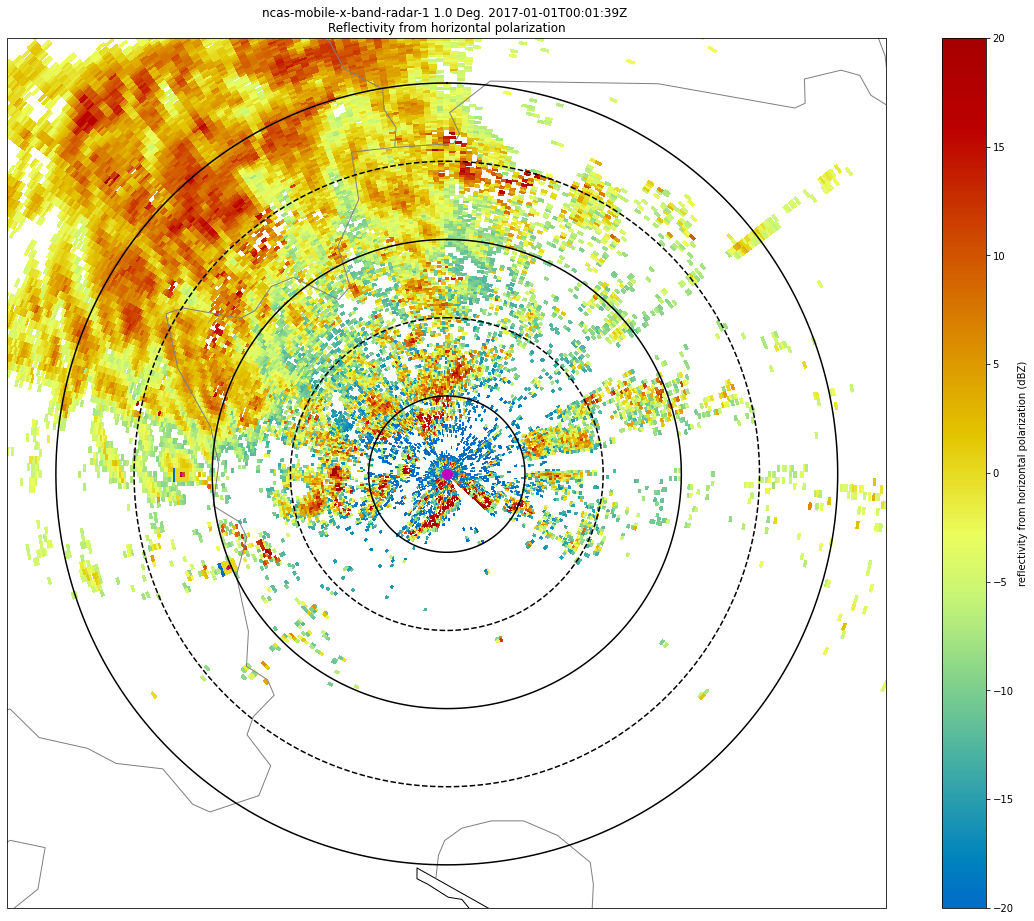

In [23]:
display = pyart.graph.RadarMapDisplay(radar)
fig = plt.figure(figsize = (20,16))
fig.patch.set_facecolor('white')

# Setting projection and ploting the second tilt
projection = ccrs.LambertConformal(central_latitude=radar.latitude['data'][0],
                                   central_longitude=radar.longitude['data'][0])




display.plot_ppi_map('dBZ',1 , vmin=-20, vmax=20, resolution='10m', projection=projection,
                     min_lon=radar.longitude['data'][0]-0.4, max_lon=radar.longitude['data'][0]+0.4, 
                     min_lat=radar.latitude['data'][0]-0.25, max_lat=radar.latitude['data'][0]+0.25,
                     fig=fig, lat_0=radar.latitude['data'][0],
                     lon_0=radar.longitude['data'][0],cmap='pyart_HomeyerRainbow')

# Plot range rings at 10, 20, 30, 40km
display.plot_range_ring(5., line_style='k-')
display.plot_range_ring(10., line_style='k--')
display.plot_range_ring(15., line_style='k-')
display.plot_range_ring(20., line_style='k--')
display.plot_range_ring(25., line_style='k-')

# Plot cross hairs

# Indicate the radar location with a point
display.plot_point(radar.longitude['data'][0], radar.latitude['data'][0],symbol='mo',markersize=10)

display.plot_point(Porton_Down_Long, Porton_Down_Lat,symbol='m*',markersize=2)

display.plot_point(Bentley_Wood_Long, Bentley_Wood_Lat,symbol='mh',markersize=2)


In [24]:
#Extract data and put in dataframe
Porton_Down={}
Bentley_Wood={}
Porton_Down_2x1={}
Bentley_Wood_2x1={}
Porton_Down_4x2={}
Bentley_Wood_4x2={}
Porton_Down_6x3={}
Bentley_Wood_6x3={}
Porton_Down_7x3={}
Bentley_Wood_7x3={}


fields=['RhoHV', 'SNRv', 'ZDR', 'dBZ', 'uKDPu', 'PhiDP', 'dBuZ', 'uPhiDP', 'KDP', 'dBZv', 'dBuZv', 'SNRvu', 'RhoHVu', 'SNRu', 'ZDRu', 'u_wind_component', 'temperature', 'uPhiDPu', 'rh', 'v_wind_component', 'SNR', 'uKDP']

for v in fields:
    Porton_Down["{0}".format(v)] = np.array([])
    Bentley_Wood["{0}".format(v)] = np.array([])
    Porton_Down_7x3["{0}".format(v)] = np.array([])
    Bentley_Wood_7x3["{0}".format(v)] = np.array([])
    
files=all_files(data_dir,date_str)
print(len(files))
print(files[0])
print(files[-1])    
for idx, f in enumerate(files[:]):
    print(f)
    radar=pyart.io.read(f)
    
    Porton_Down_Azis_Idx_1x1,Porton_Down_Ranges_Idx_1x1, Porton_Down_Azis_1x1, Porton_Down_Ranges_1x1, Porton_Down_X_1x1, Porton_Down_Y_1x1, Porton_Down_Z_1x1 =find_nearest_1x1( radar,radar_to_Porton_Down_Bearing,radar_to_Porton_Down_Distance,Porton_Down_Alt)
    Bentley_Wood_Azis_Idx_1x1,Bentley_Wood_Ranges_Idx_1x1, Bentley_Wood_Azis_1x1, Bentley_Wood_Ranges_1x1, Bentley_Wood_X_1x1, Bentley_Wood_Y_1x1, Bentley_Wood_Z_1x1 =find_nearest_1x1(radar,radar_to_Bentley_Wood_Bearing, radar_to_Bentley_Wood_Distance,Bentley_Wood_Alt)
    
    Porton_Down_Azis_Idx_2x1,Porton_Down_Ranges_Idx_2x1, Porton_Down_Azis_2x1, Porton_Down_Ranges_2x1, Porton_Down_X_2x1, Porton_Down_Y_2x1, Porton_Down_Z_2x1 =find_nearest_2x1( radar,radar_to_Porton_Down_Bearing,radar_to_Porton_Down_Distance,Porton_Down_Alt)
    Bentley_Wood_Azis_Idx_2x1,Bentley_Wood_Ranges_Idx_2x1, Bentley_Wood_Azis_2x1, Bentley_Wood_Ranges_2x1, Bentley_Wood_X_2x1, Bentley_Wood_Y_2x1, Bentley_Wood_Z_2x1 =find_nearest_2x1(radar,radar_to_Bentley_Wood_Bearing, radar_to_Bentley_Wood_Distance,Bentley_Wood_Alt)
    
    Porton_Down_Azis_Idx_4x2,Porton_Down_Ranges_Idx_4x2, Porton_Down_Azis_4x2, Porton_Down_Ranges_4x2, Porton_Down_X_4x2, Porton_Down_Y_4x2, Porton_Down_Z_4x2 =find_nearest_4x2( radar,radar_to_Porton_Down_Bearing,radar_to_Porton_Down_Distance,Porton_Down_Alt)
    Bentley_Wood_Azis_Idx_4x2,Bentley_Wood_Ranges_Idx_4x2, Bentley_Wood_Azis_4x2, Bentley_Wood_Ranges_4x2, Bentley_Wood_X_4x2, Bentley_Wood_Y_4x2, Bentley_Wood_Z_4x2 =find_nearest_4x2(radar,radar_to_Bentley_Wood_Bearing, radar_to_Bentley_Wood_Distance,Bentley_Wood_Alt)
    
    Porton_Down_Azis_Idx_6x3,Porton_Down_Ranges_Idx_6x3, Porton_Down_Azis_6x3, Porton_Down_Ranges_6x3, Porton_Down_X_6x3, Porton_Down_Y_6x3, Porton_Down_Z_6x3 =find_nearest_6x3( radar,radar_to_Porton_Down_Bearing,radar_to_Porton_Down_Distance,Porton_Down_Alt)
    Bentley_Wood_Azis_Idx_6x3,Bentley_Wood_Ranges_Idx_6x3, Bentley_Wood_Azis_6x3, Bentley_Wood_Ranges_6x3, Bentley_Wood_X_6x3, Bentley_Wood_Y_6x3, Bentley_Wood_Z_6x3 =find_nearest_6x3(radar,radar_to_Bentley_Wood_Bearing, radar_to_Bentley_Wood_Distance,Bentley_Wood_Alt)
    
    Porton_Down_Azis_Idx_7x3,Porton_Down_Ranges_Idx_7x3, Porton_Down_Azis_7x3, Porton_Down_Ranges_7x3, Porton_Down_X_7x3, Porton_Down_Y_7x3, Porton_Down_Z_7x3  =find_nearest_7x3( radar,radar_to_Porton_Down_Bearing,radar_to_Porton_Down_Distance,Porton_Down_Alt)
    Bentley_Wood_Azis_Idx_7x3,Bentley_Wood_Ranges_Idx_7x3, Bentley_Wood_Azis_7x3, Bentley_Wood_Ranges_7x3, Bentley_Wood_X_7x3, Bentley_Wood_Y_7x3, Bentley_Wood_Z_7x3 =find_nearest_7x3(radar,radar_to_Bentley_Wood_Bearing, radar_to_Bentley_Wood_Distance,Bentley_Wood_Alt)

    
    for k in Porton_Down.keys():
        Porton_Down_k_2x1=[np.append(pyart.util.datetime_from_radar(radar),np.nanmean(radar.fields[k]['data'][Porton_Down_Azis_Idx_2x1,Porton_Down_Ranges_Idx_2x1].data,0))]
        Bentley_Wood_k_2x1=[np.append(pyart.util.datetime_from_radar(radar),np.nanmean(radar.fields[k]['data'][Bentley_Wood_Azis_Idx_2x1,Bentley_Wood_Ranges_Idx_2x1].data,0))]
        
        Porton_Down_k_4x2=[np.append(pyart.util.datetime_from_radar(radar),np.nanmean(np.nanmean(radar.fields[k]['data'][Porton_Down_Azis_Idx_4x2,Porton_Down_Ranges_Idx_4x2].data,0),0))]
        Bentley_Wood_k_4x2=[np.append(pyart.util.datetime_from_radar(radar),np.nanmean(np.nanmean(radar.fields[k]['data'][Bentley_Wood_Azis_Idx_4x2,Bentley_Wood_Ranges_Idx_4x2].data,0),0))]
        
        Porton_Down_k_6x3=[np.append(pyart.util.datetime_from_radar(radar),np.nanmean(np.nanmean(radar.fields[k]['data'][Porton_Down_Azis_Idx_6x3,Porton_Down_Ranges_Idx_6x3].data,0),0))]
        Bentley_Wood_k_6x3=[np.append(pyart.util.datetime_from_radar(radar),np.nanmean(np.nanmean(radar.fields[k]['data'][Bentley_Wood_Azis_Idx_6x3,Bentley_Wood_Ranges_Idx_6x3].data,0),0))]
        
        Porton_Down_k_7x3=[np.append(pyart.util.datetime_from_radar(radar),np.nanmean(np.nanmean(radar.fields[k]['data'][Porton_Down_Azis_Idx_7x3,Porton_Down_Ranges_Idx_7x3].data,0),0))]
        Bentley_Wood_k_7x3=[np.append(pyart.util.datetime_from_radar(radar),np.nanmean(np.nanmean(radar.fields[k]['data'][Bentley_Wood_Azis_Idx_7x3,Bentley_Wood_Ranges_Idx_7x3].data,0),0))]

        if idx==0:
            Porton_Down[k]=[np.append(pyart.util.datetime_from_radar(radar),np.squeeze([radar.fields[k]['data'][Porton_Down_Azis_Idx_1x1,Porton_Down_Ranges_Idx_1x1].data]))]
            Bentley_Wood[k]=[np.append(pyart.util.datetime_from_radar(radar),np.squeeze([radar.fields[k]['data'][Bentley_Wood_Azis_Idx_1x1,Bentley_Wood_Ranges_Idx_1x1].data]))]
            
            Porton_Down_2x1[k]=Porton_Down_k_2x1
            Bentley_Wood_2x1[k]=Bentley_Wood_k_2x1
            
            Porton_Down_4x2[k]=Porton_Down_k_4x2
            Bentley_Wood_4x2[k]=Bentley_Wood_k_4x2
            
            Porton_Down_6x3[k]=Porton_Down_k_6x3
            Bentley_Wood_6x3[k]=Bentley_Wood_k_6x3
            
            Porton_Down_7x3[k]=Porton_Down_k_7x3
            Bentley_Wood_7x3[k]=Bentley_Wood_k_7x3
        else:
            Porton_Down[k]=np.append(Porton_Down[k],[np.append(pyart.util.datetime_from_radar(radar),np.squeeze([radar.fields[k]['data'][Porton_Down_Azis_Idx[:],Porton_Down_Ranges_Idx].data]))],0)
            Bentley_Wood[k]=np.append(Bentley_Wood[k],[np.append(pyart.util.datetime_from_radar(radar),np.squeeze([radar.fields[k]['data'][Bentley_Wood_Azis_Idx[:],Bentley_Wood_Ranges_Idx].data]))],0)
            
            Porton_Down_2x1[k]=np.append(Porton_Down_2x1[k],Porton_Down_k_2x1,0)
            Bentley_Wood_2x1[k]=np.append(Bentley_Wood_2x1[k],Bentley_Wood_k_2x1,0)
            
            Porton_Down_4x2[k]=np.append(Porton_Down_4x2[k],Porton_Down_k_4x2,0)
            Bentley_Wood_4x2[k]=np.append(Bentley_Wood_4x2[k],Bentley_Wood_k_4x2,0)
            
            Porton_Down_6x3[k]=np.append(Porton_Down_6x3[k],Porton_Down_k_6x3,0)
            Bentley_Wood_6x3[k]=np.append(Bentley_Wood_6x3[k],Bentley_Wood_k_6x3,0)
            
            Porton_Down_7x3[k]=np.append(Porton_Down_7x3[k],Porton_Down_k_7x3,0)
            Bentley_Wood_7x3[k]=np.append(Bentley_Wood_7x3[k],Bentley_Wood_k_7x3,0)
            
    del radar

#Write dictionary to dataframes and output into excel
radar=pyart.io.read(f)

Porton_Down_Vars=[]
Bentley_Wood_Vars=[]

Porton_Down_Vars_2x1=[]
Bentley_Wood_Vars_2x1=[]

Porton_Down_Vars_4x2=[]
Bentley_Wood_Vars_4x2=[]

Porton_Down_Vars_6x3=[]
Bentley_Wood_Vars_6x3=[]

Porton_Down_Vars_7x3=[]
Bentley_Wood_Vars_7x3=[]
wpath='/gws/smf/j04/ncas_radar/rrniii/BioDAR/notebooks/Jan2017'

try:
    os.remove(wpath + '/Porton_Down_Closest_1x1.xlsx')
    os.remove(wpath + '/Bentley_Wood_Closest_1x1.xlsx')

    os.remove(wpath + '/Porton_Down_Closest_2x1.xlsx')
    os.remove(wpath + '/Bentley_Wood_Closest_2x1.xlsx')
    
    os.remove(wpath + '/Porton_Down_Closest_4x2.xlsx')
    os.remove(wpath + '/Bentley_Wood_Closest_4x2.xlsx')
    
    os.remove(wpath + '/Porton_Down_Closest_6x3.xlsx')
    os.remove(wpath + '/Bentley_Wood_Closest_6x3.xlsx')
    
    os.remove(wpath + '/Porton_Down_Closest_7x3.xlsx')
    os.remove(wpath + '/Bentley_Wood_Closest_7x3.xlsx')
except:
    print('No File')

for kidx, k in enumerate(Porton_Down.keys()):
  
    Porton_Down_Vars=np.append(Porton_Down_Vars,'Porton_Down_'+str(k))
    Bentley_Wood_Vars=np.append(Bentley_Wood_Vars,'Bentley_Wood_'+str(k))
    
    Porton_Down_Vars_2x1=np.append(Porton_Down_Vars_2x1,'Porton_Down_2x1_'+str(k))
    Bentley_Wood_Vars_2x1=np.append(Bentley_Wood_Vars_2x1,'Bentley_Wood_2x1_'+str(k))
    
    Porton_Down_Vars_4x2=np.append(Porton_Down_Vars_4x2,'Porton_Down_4x2_'+str(k))
    Bentley_Wood_Vars_4x2=np.append(Bentley_Wood_Vars_4x2,'Bentley_Wood_4x2_'+str(k))
    
    Porton_Down_Vars_7x3=np.append(Porton_Down_Vars_6x3,'Porton_Down_6x3_'+str(k))
    Bentley_Wood_Vars_7x3=np.append(Bentley_Wood_Vars_6x3,'Bentley_Wood_6x3_'+str(k))
    
    Porton_Down_Vars_7x3=np.append(Porton_Down_Vars_7x3,'Porton_Down_7x3_'+str(k))
    Bentley_Wood_Vars_7x3=np.append(Bentley_Wood_Vars_7x3,'Bentley_Wood_7x3_'+str(k))

    globals()['Porton_Down_'+str(k)]=pd.DataFrame(Porton_Down[k],columns=[np.append('Date Time', radar.fixed_angle['data'].data.astype('str'))])
    globals()['Bentley_Wood_'+str(k)]=pd.DataFrame(Bentley_Wood[k],columns=[np.append('Date Time', radar.fixed_angle['data'].data.astype('str'))])

    globals()['Porton_Down_2x1_'+str(k)]=pd.DataFrame(Porton_Down_2x1[k],columns=[np.append('Date Time', radar.fixed_angle['data'].data.astype('str'))])
    globals()['Bentley_Wood_2x1_'+str(k)]=pd.DataFrame(Bentley_Wood_2x1[k],columns=[np.append('Date Time', radar.fixed_angle['data'].data.astype('str'))])
    
    globals()['Porton_Down_4x2_'+str(k)]=pd.DataFrame(Porton_Down_4x2[k],columns=[np.append('Date Time', radar.fixed_angle['data'].data.astype('str'))])
    globals()['Bentley_Wood_4x2_'+str(k)]=pd.DataFrame(Bentley_Wood_4x2[k],columns=[np.append('Date Time', radar.fixed_angle['data'].data.astype('str'))])
    
    globals()['Porton_Down_6x3_'+str(k)]=pd.DataFrame(Porton_Down_6x3[k],columns=[np.append('Date Time', radar.fixed_angle['data'].data.astype('str'))])
    globals()['Bentley_Wood_6x3_'+str(k)]=pd.DataFrame(Bentley_Wood_6x3[k],columns=[np.append('Date Time', radar.fixed_angle['data'].data.astype('str'))])
    
    globals()['Porton_Down_7x3_'+str(k)]=pd.DataFrame(Porton_Down_7x3[k],columns=[np.append('Date Time', radar.fixed_angle['data'].data.astype('str'))])
    globals()['Bentley_Wood_7x3_'+str(k)]=pd.DataFrame(Bentley_Wood_7x3[k],columns=[np.append('Date Time', radar.fixed_angle['data'].data.astype('str'))])

    if kidx==0:
        globals()['Porton_Down_'+str(k)].to_excel("Porton_Down_Closest_1x1.xlsx", sheet_name='Porton_Down_1x1_'+str(k))
        globals()['Bentley_Wood_'+str(k)].to_excel("Bentley_Wood_Closest_1x1.xlsx", sheet_name='Bentley_Wood_1x1_'+str(k)) 
        
        globals()['Porton_Down_2x1_'+str(k)].to_excel("Porton_Down_Closest_2x1.xlsx", sheet_name='Porton_Down_2x1_'+str(k))
        globals()['Bentley_Wood_2x1_'+str(k)].to_excel("Bentley_Wood_Closest_2x1.xlsx", sheet_name='Bentley_Wood_2x1_'+str(k)) 

        globals()['Porton_Down_4x2_'+str(k)].to_excel("Porton_Down_Closest_4x2.xlsx", sheet_name='Porton_Down_4x2_'+str(k))
        globals()['Bentley_Wood_4x2_'+str(k)].to_excel("Bentley_Wood_Closest_4x2.xlsx", sheet_name='Bentley_Wood_4x2_'+str(k)) 

        globals()['Porton_Down_6x3_'+str(k)].to_excel("Porton_Down_Closest_6x3.xlsx", sheet_name='Porton_Down_6x3_'+str(k))
        globals()['Bentley_Wood_6x3_'+str(k)].to_excel("Bentley_Wood_Closest_6x3.xlsx", sheet_name='Bentley_Wood_6x3_'+str(k)) 

        globals()['Porton_Down_7x3_'+str(k)].to_excel("Porton_Down_Closest_7x3.xlsx", sheet_name='Porton_Down_7x3_'+str(k))
        globals()['Bentley_Wood_7x3_'+str(k)].to_excel("Bentley_Wood_Closest_7x3.xlsx", sheet_name='Bentley_Wood_7x3_'+str(k)) 

    else:
        with pd.ExcelWriter('Porton_Down_Closest_1x1.xlsx', mode='a') as writer:  
            globals()['Porton_Down_'+str(k)].to_excel(writer, sheet_name='Porton_Down_1x1_'+str(k)) 
        with pd.ExcelWriter('Bentley_Wood_Closest_1x1.xlsx', mode='a') as writer:  
            globals()['Bentley_Wood_'+str(k)].to_excel(writer, sheet_name='Bentley_Wood_1x1_'+str(k)) 
            
        with pd.ExcelWriter('Porton_Down_Closest_2x1.xlsx', mode='a') as writer:  
            globals()['Porton_Down_2x1_'+str(k)].to_excel(writer, sheet_name='Porton_Down_2x1_'+str(k)) 
        with pd.ExcelWriter('Bentley_Wood_Closest_2x1.xlsx', mode='a') as writer:  
            globals()['Bentley_Wood_2x1_'+str(k)].to_excel(writer, sheet_name='Bentley_Wood_2x1_'+str(k)) 
        
        with pd.ExcelWriter('Porton_Down_Closest_4x2.xlsx', mode='a') as writer:  
            globals()['Porton_Down_4x2_'+str(k)].to_excel(writer, sheet_name='Porton_Down_4x2_'+str(k)) 
        with pd.ExcelWriter('Bentley_zzYes    yes Wood_Closest_4x2.xlsx', mode='a') as writer:  
            globals()['Bentley_Wood_4x2_'+str(k)].to_excel(writer, sheet_name='Bentley_Wood_4x2_'+str(k)) 
        
        with pd.ExcelWriter('Porton_Down_Closest_6x3.xlsx', mode='a') as writer:  
            globals()['Porton_Down_6x3_'+str(k)].to_excel(writer, sheet_name='Porton_Down_6x3_'+str(k)) 
        with pd.ExcelWriter('Bentley_Wood_Closest_6x3.xlsx', mode='a') as writer:  
            globals()['Bentley_Wood_6x3_'+str(k)].to_excel(writer, sheet_name='Bentley_Wood_6x3_'+str(k)) 
            
        with pd.ExcelWriter('Porton_Down_Closest_7x3.xlsx', mode='a') as writer:  
            globals()['Porton_Down_7x3_'+str(k)].to_excel(writer, sheet_name='Porton_Down_7x3_'+str(k)) 
        with pd.ExcelWriter('Bentley_Wood_Closest_7x3.xlsx', mode='a') as writer:  
            globals()['Bentley_Wood_7x3_'+str(k)].to_excel(writer, sheet_name='Bentley_Wood_7x3_'+str(k)) 

/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/**/*chilbolton_201701*.nc
7509
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170101/ncas-mobile-x-band-radar-1_chilbolton_20170101-000108_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170131/ncas-mobile-x-band-radar-1_chilbolton_20170131-235423_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170101/ncas-mobile-x-band-radar-1_chilbolton_20170101-000108_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170101/ncas-mobile-x-band-radar-1_chilbolton_20170101-000703_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170101/ncas-mobile-x-band-radar-1_chilbolton_20170101-001257_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170101/ncas-mobile-x-band-radar-1_chilbolton_20170101-001852

/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170101/ncas-mobile-x-band-radar-1_chilbolton_20170101-050943_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170101/ncas-mobile-x-band-radar-1_chilbolton_20170101-051538_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170101/ncas-mobile-x-band-radar-1_chilbolton_20170101-052132_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170101/ncas-mobile-x-band-radar-1_chilbolton_20170101-052727_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170101/ncas-mobile-x-band-radar-1_chilbolton_20170101-053339_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170101/ncas-mobile-x-band-radar-1_chilbolton_20170101-053932_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170101/ncas-mo

/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170101/ncas-mobile-x-band-radar-1_chilbolton_20170101-103628_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170101/ncas-mobile-x-band-radar-1_chilbolton_20170101-104221_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170101/ncas-mobile-x-band-radar-1_chilbolton_20170101-104816_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170101/ncas-mobile-x-band-radar-1_chilbolton_20170101-105410_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170101/ncas-mobile-x-band-radar-1_chilbolton_20170101-110004_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170101/ncas-mobile-x-band-radar-1_chilbolton_20170101-110559_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170101/ncas-mo

/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170101/ncas-mobile-x-band-radar-1_chilbolton_20170101-160341_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170101/ncas-mobile-x-band-radar-1_chilbolton_20170101-160937_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170101/ncas-mobile-x-band-radar-1_chilbolton_20170101-161533_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170101/ncas-mobile-x-band-radar-1_chilbolton_20170101-162128_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170101/ncas-mobile-x-band-radar-1_chilbolton_20170101-162723_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170101/ncas-mobile-x-band-radar-1_chilbolton_20170101-163337_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170101/ncas-mo

/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170101/ncas-mobile-x-band-radar-1_chilbolton_20170101-213107_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170101/ncas-mobile-x-band-radar-1_chilbolton_20170101-213700_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170101/ncas-mobile-x-band-radar-1_chilbolton_20170101-214256_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170101/ncas-mobile-x-band-radar-1_chilbolton_20170101-214852_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170101/ncas-mobile-x-band-radar-1_chilbolton_20170101-215447_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170101/ncas-mobile-x-band-radar-1_chilbolton_20170101-220042_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170101/ncas-mo

/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170102/ncas-mobile-x-band-radar-1_chilbolton_20170102-025742_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170102/ncas-mobile-x-band-radar-1_chilbolton_20170102-030340_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170102/ncas-mobile-x-band-radar-1_chilbolton_20170102-030935_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170102/ncas-mobile-x-band-radar-1_chilbolton_20170102-031530_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170102/ncas-mobile-x-band-radar-1_chilbolton_20170102-032124_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170102/ncas-mobile-x-band-radar-1_chilbolton_20170102-032718_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170102/ncas-mo

/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170102/ncas-mobile-x-band-radar-1_chilbolton_20170102-082408_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170102/ncas-mobile-x-band-radar-1_chilbolton_20170102-083003_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170102/ncas-mobile-x-band-radar-1_chilbolton_20170102-083614_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170102/ncas-mobile-x-band-radar-1_chilbolton_20170102-084207_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170102/ncas-mobile-x-band-radar-1_chilbolton_20170102-084803_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170102/ncas-mobile-x-band-radar-1_chilbolton_20170102-085358_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170102/ncas-mo

/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170102/ncas-mobile-x-band-radar-1_chilbolton_20170102-135049_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170102/ncas-mobile-x-band-radar-1_chilbolton_20170102-135644_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170102/ncas-mobile-x-band-radar-1_chilbolton_20170102-140239_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170102/ncas-mobile-x-band-radar-1_chilbolton_20170102-140834_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170102/ncas-mobile-x-band-radar-1_chilbolton_20170102-141429_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170102/ncas-mobile-x-band-radar-1_chilbolton_20170102-142023_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170102/ncas-mo

/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170102/ncas-mobile-x-band-radar-1_chilbolton_20170102-191718_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170102/ncas-mobile-x-band-radar-1_chilbolton_20170102-192313_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170102/ncas-mobile-x-band-radar-1_chilbolton_20170102-192908_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170102/ncas-mobile-x-band-radar-1_chilbolton_20170102-193520_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170102/ncas-mobile-x-band-radar-1_chilbolton_20170102-194113_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170102/ncas-mobile-x-band-radar-1_chilbolton_20170102-194708_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170102/ncas-mo

/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170103/ncas-mobile-x-band-radar-1_chilbolton_20170103-004355_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170103/ncas-mobile-x-band-radar-1_chilbolton_20170103-004950_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170103/ncas-mobile-x-band-radar-1_chilbolton_20170103-005546_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170103/ncas-mobile-x-band-radar-1_chilbolton_20170103-010141_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170103/ncas-mobile-x-band-radar-1_chilbolton_20170103-010736_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170103/ncas-mobile-x-band-radar-1_chilbolton_20170103-011330_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170103/ncas-mo

/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170103/ncas-mobile-x-band-radar-1_chilbolton_20170103-061026_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170103/ncas-mobile-x-band-radar-1_chilbolton_20170103-061621_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170103/ncas-mobile-x-band-radar-1_chilbolton_20170103-062216_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170103/ncas-mobile-x-band-radar-1_chilbolton_20170103-062810_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170103/ncas-mobile-x-band-radar-1_chilbolton_20170103-063422_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170103/ncas-mobile-x-band-radar-1_chilbolton_20170103-064015_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170103/ncas-mo

/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170103/ncas-mobile-x-band-radar-1_chilbolton_20170103-113703_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170103/ncas-mobile-x-band-radar-1_chilbolton_20170103-114257_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170103/ncas-mobile-x-band-radar-1_chilbolton_20170103-114852_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170103/ncas-mobile-x-band-radar-1_chilbolton_20170103-115446_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170103/ncas-mobile-x-band-radar-1_chilbolton_20170103-120041_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170103/ncas-mobile-x-band-radar-1_chilbolton_20170103-120636_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170103/ncas-mo

/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170103/ncas-mobile-x-band-radar-1_chilbolton_20170103-170332_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170103/ncas-mobile-x-band-radar-1_chilbolton_20170103-170927_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170103/ncas-mobile-x-band-radar-1_chilbolton_20170103-171521_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170103/ncas-mobile-x-band-radar-1_chilbolton_20170103-172116_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170103/ncas-mobile-x-band-radar-1_chilbolton_20170103-172710_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170103/ncas-mobile-x-band-radar-1_chilbolton_20170103-173322_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170103/ncas-mo

/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170103/ncas-mobile-x-band-radar-1_chilbolton_20170103-222958_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170103/ncas-mobile-x-band-radar-1_chilbolton_20170103-223610_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170103/ncas-mobile-x-band-radar-1_chilbolton_20170103-224204_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170103/ncas-mobile-x-band-radar-1_chilbolton_20170103-224759_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170103/ncas-mobile-x-band-radar-1_chilbolton_20170103-225353_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170103/ncas-mobile-x-band-radar-1_chilbolton_20170103-225948_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170103/ncas-mo

/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170104/ncas-mobile-x-band-radar-1_chilbolton_20170104-035640_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170104/ncas-mobile-x-band-radar-1_chilbolton_20170104-040235_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170104/ncas-mobile-x-band-radar-1_chilbolton_20170104-040829_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170104/ncas-mobile-x-band-radar-1_chilbolton_20170104-041424_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170104/ncas-mobile-x-band-radar-1_chilbolton_20170104-042018_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170104/ncas-mobile-x-band-radar-1_chilbolton_20170104-042612_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170104/ncas-mo

/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170104/ncas-mobile-x-band-radar-1_chilbolton_20170104-092307_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170104/ncas-mobile-x-band-radar-1_chilbolton_20170104-092902_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170104/ncas-mobile-x-band-radar-1_chilbolton_20170104-093514_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170104/ncas-mobile-x-band-radar-1_chilbolton_20170104-094106_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170104/ncas-mobile-x-band-radar-1_chilbolton_20170104-094702_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170104/ncas-mobile-x-band-radar-1_chilbolton_20170104-095257_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170104/ncas-mo

/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170104/ncas-mobile-x-band-radar-1_chilbolton_20170104-144953_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170104/ncas-mobile-x-band-radar-1_chilbolton_20170104-145548_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170104/ncas-mobile-x-band-radar-1_chilbolton_20170104-150143_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170104/ncas-mobile-x-band-radar-1_chilbolton_20170104-150738_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170104/ncas-mobile-x-band-radar-1_chilbolton_20170104-151333_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170104/ncas-mobile-x-band-radar-1_chilbolton_20170104-151928_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170104/ncas-mo

/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170104/ncas-mobile-x-band-radar-1_chilbolton_20170104-201626_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170104/ncas-mobile-x-band-radar-1_chilbolton_20170104-202220_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170104/ncas-mobile-x-band-radar-1_chilbolton_20170104-202814_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170104/ncas-mobile-x-band-radar-1_chilbolton_20170104-203426_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170104/ncas-mobile-x-band-radar-1_chilbolton_20170104-204019_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170104/ncas-mobile-x-band-radar-1_chilbolton_20170104-204614_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170104/ncas-mo

/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170105/ncas-mobile-x-band-radar-1_chilbolton_20170105-014303_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170105/ncas-mobile-x-band-radar-1_chilbolton_20170105-014858_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170105/ncas-mobile-x-band-radar-1_chilbolton_20170105-015453_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170105/ncas-mobile-x-band-radar-1_chilbolton_20170105-020047_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170105/ncas-mobile-x-band-radar-1_chilbolton_20170105-020642_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170105/ncas-mobile-x-band-radar-1_chilbolton_20170105-021237_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170105/ncas-mo

/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170105/ncas-mobile-x-band-radar-1_chilbolton_20170105-070928_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170105/ncas-mobile-x-band-radar-1_chilbolton_20170105-071522_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170105/ncas-mobile-x-band-radar-1_chilbolton_20170105-072117_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170105/ncas-mobile-x-band-radar-1_chilbolton_20170105-072712_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170105/ncas-mobile-x-band-radar-1_chilbolton_20170105-073324_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170105/ncas-mobile-x-band-radar-1_chilbolton_20170105-073916_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170105/ncas-mo

/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170105/ncas-mobile-x-band-radar-1_chilbolton_20170105-123609_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170105/ncas-mobile-x-band-radar-1_chilbolton_20170105-124203_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170105/ncas-mobile-x-band-radar-1_chilbolton_20170105-124759_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170105/ncas-mobile-x-band-radar-1_chilbolton_20170105-125354_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170105/ncas-mobile-x-band-radar-1_chilbolton_20170105-125948_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170105/ncas-mobile-x-band-radar-1_chilbolton_20170105-130542_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170105/ncas-mo

/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170105/ncas-mobile-x-band-radar-1_chilbolton_20170105-180238_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170105/ncas-mobile-x-band-radar-1_chilbolton_20170105-180833_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170105/ncas-mobile-x-band-radar-1_chilbolton_20170105-181427_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170105/ncas-mobile-x-band-radar-1_chilbolton_20170105-182022_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170105/ncas-mobile-x-band-radar-1_chilbolton_20170105-182617_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170105/ncas-mobile-x-band-radar-1_chilbolton_20170105-183229_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170105/ncas-mo

/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170105/ncas-mobile-x-band-radar-1_chilbolton_20170105-232905_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170105/ncas-mobile-x-band-radar-1_chilbolton_20170105-233517_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170105/ncas-mobile-x-band-radar-1_chilbolton_20170105-234111_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170105/ncas-mobile-x-band-radar-1_chilbolton_20170105-234705_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170105/ncas-mobile-x-band-radar-1_chilbolton_20170105-235300_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170105/ncas-mobile-x-band-radar-1_chilbolton_20170105-235854_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170106/ncas-mo

/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170106/ncas-mobile-x-band-radar-1_chilbolton_20170106-045550_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170106/ncas-mobile-x-band-radar-1_chilbolton_20170106-050144_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170106/ncas-mobile-x-band-radar-1_chilbolton_20170106-050738_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170106/ncas-mobile-x-band-radar-1_chilbolton_20170106-051333_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170106/ncas-mobile-x-band-radar-1_chilbolton_20170106-051927_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170106/ncas-mobile-x-band-radar-1_chilbolton_20170106-052522_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170106/ncas-mo

/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170106/ncas-mobile-x-band-radar-1_chilbolton_20170106-102215_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170106/ncas-mobile-x-band-radar-1_chilbolton_20170106-102810_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170106/ncas-mobile-x-band-radar-1_chilbolton_20170106-103421_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170106/ncas-mobile-x-band-radar-1_chilbolton_20170106-104014_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170106/ncas-mobile-x-band-radar-1_chilbolton_20170106-104609_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170106/ncas-mobile-x-band-radar-1_chilbolton_20170106-105204_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170106/ncas-mo

/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170106/ncas-mobile-x-band-radar-1_chilbolton_20170106-154920_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170106/ncas-mobile-x-band-radar-1_chilbolton_20170106-155516_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170106/ncas-mobile-x-band-radar-1_chilbolton_20170106-160111_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170106/ncas-mobile-x-band-radar-1_chilbolton_20170106-160707_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170106/ncas-mobile-x-band-radar-1_chilbolton_20170106-161302_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170106/ncas-mobile-x-band-radar-1_chilbolton_20170106-161858_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170106/ncas-mo

/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170106/ncas-mobile-x-band-radar-1_chilbolton_20170106-211643_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170106/ncas-mobile-x-band-radar-1_chilbolton_20170106-212239_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170106/ncas-mobile-x-band-radar-1_chilbolton_20170106-212835_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170106/ncas-mobile-x-band-radar-1_chilbolton_20170106-213447_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170106/ncas-mobile-x-band-radar-1_chilbolton_20170106-214041_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170106/ncas-mobile-x-band-radar-1_chilbolton_20170106-215348_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170106/ncas-mo

/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170107/ncas-mobile-x-band-radar-1_chilbolton_20170107-025110_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170107/ncas-mobile-x-band-radar-1_chilbolton_20170107-025706_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170107/ncas-mobile-x-band-radar-1_chilbolton_20170107-030301_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170107/ncas-mobile-x-band-radar-1_chilbolton_20170107-030856_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170107/ncas-mobile-x-band-radar-1_chilbolton_20170107-031451_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170107/ncas-mobile-x-band-radar-1_chilbolton_20170107-032045_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170107/ncas-mo

/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170107/ncas-mobile-x-band-radar-1_chilbolton_20170107-081738_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170107/ncas-mobile-x-band-radar-1_chilbolton_20170107-082333_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170107/ncas-mobile-x-band-radar-1_chilbolton_20170107-082927_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170107/ncas-mobile-x-band-radar-1_chilbolton_20170107-083539_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170107/ncas-mobile-x-band-radar-1_chilbolton_20170107-084131_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170107/ncas-mobile-x-band-radar-1_chilbolton_20170107-084725_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170107/ncas-mo

/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170107/ncas-mobile-x-band-radar-1_chilbolton_20170107-134420_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170107/ncas-mobile-x-band-radar-1_chilbolton_20170107-135015_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170107/ncas-mobile-x-band-radar-1_chilbolton_20170107-135611_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170107/ncas-mobile-x-band-radar-1_chilbolton_20170107-140205_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170107/ncas-mobile-x-band-radar-1_chilbolton_20170107-140800_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170107/ncas-mobile-x-band-radar-1_chilbolton_20170107-141355_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170107/ncas-mo

/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170107/ncas-mobile-x-band-radar-1_chilbolton_20170107-191051_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170107/ncas-mobile-x-band-radar-1_chilbolton_20170107-191647_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170107/ncas-mobile-x-band-radar-1_chilbolton_20170107-192242_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170107/ncas-mobile-x-band-radar-1_chilbolton_20170107-192836_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170107/ncas-mobile-x-band-radar-1_chilbolton_20170107-193448_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170107/ncas-mobile-x-band-radar-1_chilbolton_20170107-194041_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170107/ncas-mo

/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170108/ncas-mobile-x-band-radar-1_chilbolton_20170108-003735_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170108/ncas-mobile-x-band-radar-1_chilbolton_20170108-004329_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170108/ncas-mobile-x-band-radar-1_chilbolton_20170108-004924_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170108/ncas-mobile-x-band-radar-1_chilbolton_20170108-005518_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170108/ncas-mobile-x-band-radar-1_chilbolton_20170108-010113_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170108/ncas-mobile-x-band-radar-1_chilbolton_20170108-010708_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170108/ncas-mo

/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170108/ncas-mobile-x-band-radar-1_chilbolton_20170108-060400_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170108/ncas-mobile-x-band-radar-1_chilbolton_20170108-060955_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170108/ncas-mobile-x-band-radar-1_chilbolton_20170108-061549_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170108/ncas-mobile-x-band-radar-1_chilbolton_20170108-062145_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170108/ncas-mobile-x-band-radar-1_chilbolton_20170108-062740_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170108/ncas-mobile-x-band-radar-1_chilbolton_20170108-063353_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170108/ncas-mo

/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170108/ncas-mobile-x-band-radar-1_chilbolton_20170108-113023_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170108/ncas-mobile-x-band-radar-1_chilbolton_20170108-113635_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170108/ncas-mobile-x-band-radar-1_chilbolton_20170108-114228_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170108/ncas-mobile-x-band-radar-1_chilbolton_20170108-114823_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170108/ncas-mobile-x-band-radar-1_chilbolton_20170108-115417_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170108/ncas-mobile-x-band-radar-1_chilbolton_20170108-120012_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170108/ncas-mo

/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170108/ncas-mobile-x-band-radar-1_chilbolton_20170108-165702_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170108/ncas-mobile-x-band-radar-1_chilbolton_20170108-170257_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170108/ncas-mobile-x-band-radar-1_chilbolton_20170108-170851_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170108/ncas-mobile-x-band-radar-1_chilbolton_20170108-171446_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170108/ncas-mobile-x-band-radar-1_chilbolton_20170108-172040_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170108/ncas-mobile-x-band-radar-1_chilbolton_20170108-172635_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170108/ncas-mo

/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170108/ncas-mobile-x-band-radar-1_chilbolton_20170108-222329_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170108/ncas-mobile-x-band-radar-1_chilbolton_20170108-222923_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170108/ncas-mobile-x-band-radar-1_chilbolton_20170108-223534_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170108/ncas-mobile-x-band-radar-1_chilbolton_20170108-224127_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170108/ncas-mobile-x-band-radar-1_chilbolton_20170108-224722_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170108/ncas-mobile-x-band-radar-1_chilbolton_20170108-225317_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170108/ncas-mo

/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170109/ncas-mobile-x-band-radar-1_chilbolton_20170109-035029_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170109/ncas-mobile-x-band-radar-1_chilbolton_20170109-035623_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170109/ncas-mobile-x-band-radar-1_chilbolton_20170109-040219_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170109/ncas-mobile-x-band-radar-1_chilbolton_20170109-040815_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170109/ncas-mobile-x-band-radar-1_chilbolton_20170109-041409_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170109/ncas-mobile-x-band-radar-1_chilbolton_20170109-042003_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170109/ncas-mo

/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170109/ncas-mobile-x-band-radar-1_chilbolton_20170109-091657_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170109/ncas-mobile-x-band-radar-1_chilbolton_20170109-092253_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170109/ncas-mobile-x-band-radar-1_chilbolton_20170109-092848_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170109/ncas-mobile-x-band-radar-1_chilbolton_20170109-093500_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170109/ncas-mobile-x-band-radar-1_chilbolton_20170109-094054_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170109/ncas-mobile-x-band-radar-1_chilbolton_20170109-094649_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170109/ncas-mo

/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170109/ncas-mobile-x-band-radar-1_chilbolton_20170109-144425_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170109/ncas-mobile-x-band-radar-1_chilbolton_20170109-145020_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170109/ncas-mobile-x-band-radar-1_chilbolton_20170109-145616_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170109/ncas-mobile-x-band-radar-1_chilbolton_20170109-150211_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170109/ncas-mobile-x-band-radar-1_chilbolton_20170109-150806_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170109/ncas-mobile-x-band-radar-1_chilbolton_20170109-151402_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170109/ncas-mo

/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170109/ncas-mobile-x-band-radar-1_chilbolton_20170109-201102_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170109/ncas-mobile-x-band-radar-1_chilbolton_20170109-201657_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170109/ncas-mobile-x-band-radar-1_chilbolton_20170109-202251_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170109/ncas-mobile-x-band-radar-1_chilbolton_20170109-202845_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170109/ncas-mobile-x-band-radar-1_chilbolton_20170109-203456_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170109/ncas-mobile-x-band-radar-1_chilbolton_20170109-204049_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170109/ncas-mo

/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170110/ncas-mobile-x-band-radar-1_chilbolton_20170110-013742_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170110/ncas-mobile-x-band-radar-1_chilbolton_20170110-014337_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170110/ncas-mobile-x-band-radar-1_chilbolton_20170110-014931_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170110/ncas-mobile-x-band-radar-1_chilbolton_20170110-015526_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170110/ncas-mobile-x-band-radar-1_chilbolton_20170110-020120_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170110/ncas-mobile-x-band-radar-1_chilbolton_20170110-020715_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170110/ncas-mo

/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170110/ncas-mobile-x-band-radar-1_chilbolton_20170110-070411_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170110/ncas-mobile-x-band-radar-1_chilbolton_20170110-071006_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170110/ncas-mobile-x-band-radar-1_chilbolton_20170110-071602_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170110/ncas-mobile-x-band-radar-1_chilbolton_20170110-072156_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170110/ncas-mobile-x-band-radar-1_chilbolton_20170110-072751_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170110/ncas-mobile-x-band-radar-1_chilbolton_20170110-073403_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170110/ncas-mo

/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170110/ncas-mobile-x-band-radar-1_chilbolton_20170110-123059_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170110/ncas-mobile-x-band-radar-1_chilbolton_20170110-123652_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170110/ncas-mobile-x-band-radar-1_chilbolton_20170110-124247_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170110/ncas-mobile-x-band-radar-1_chilbolton_20170110-124842_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170110/ncas-mobile-x-band-radar-1_chilbolton_20170110-125437_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170110/ncas-mobile-x-band-radar-1_chilbolton_20170110-130032_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170110/ncas-mo

/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170110/ncas-mobile-x-band-radar-1_chilbolton_20170110-175730_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170110/ncas-mobile-x-band-radar-1_chilbolton_20170110-180325_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170110/ncas-mobile-x-band-radar-1_chilbolton_20170110-180920_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170110/ncas-mobile-x-band-radar-1_chilbolton_20170110-181515_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170110/ncas-mobile-x-band-radar-1_chilbolton_20170110-182110_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170110/ncas-mobile-x-band-radar-1_chilbolton_20170110-182704_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170110/ncas-mo

/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170110/ncas-mobile-x-band-radar-1_chilbolton_20170110-232359_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170110/ncas-mobile-x-band-radar-1_chilbolton_20170110-232953_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170110/ncas-mobile-x-band-radar-1_chilbolton_20170110-233604_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170110/ncas-mobile-x-band-radar-1_chilbolton_20170110-234159_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170110/ncas-mobile-x-band-radar-1_chilbolton_20170110-234754_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170110/ncas-mobile-x-band-radar-1_chilbolton_20170110-235348_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170110/ncas-mo

/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170111/ncas-mobile-x-band-radar-1_chilbolton_20170111-045051_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170111/ncas-mobile-x-band-radar-1_chilbolton_20170111-045646_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170111/ncas-mobile-x-band-radar-1_chilbolton_20170111-050241_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170111/ncas-mobile-x-band-radar-1_chilbolton_20170111-050836_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170111/ncas-mobile-x-band-radar-1_chilbolton_20170111-051431_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170111/ncas-mobile-x-band-radar-1_chilbolton_20170111-052026_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170111/ncas-mo

/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170111/ncas-mobile-x-band-radar-1_chilbolton_20170111-101721_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170111/ncas-mobile-x-band-radar-1_chilbolton_20170111-102316_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170111/ncas-mobile-x-band-radar-1_chilbolton_20170111-102910_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170111/ncas-mobile-x-band-radar-1_chilbolton_20170111-103521_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170111/ncas-mobile-x-band-radar-1_chilbolton_20170111-104114_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170111/ncas-mobile-x-band-radar-1_chilbolton_20170111-104708_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170111/ncas-mo

/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170111/ncas-mobile-x-band-radar-1_chilbolton_20170111-154404_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170111/ncas-mobile-x-band-radar-1_chilbolton_20170111-154959_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170111/ncas-mobile-x-band-radar-1_chilbolton_20170111-155553_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170111/ncas-mobile-x-band-radar-1_chilbolton_20170111-160148_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170111/ncas-mobile-x-band-radar-1_chilbolton_20170111-160743_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170111/ncas-mobile-x-band-radar-1_chilbolton_20170111-161338_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170111/ncas-mo

/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170111/ncas-mobile-x-band-radar-1_chilbolton_20170111-211033_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170111/ncas-mobile-x-band-radar-1_chilbolton_20170111-211628_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170111/ncas-mobile-x-band-radar-1_chilbolton_20170111-212223_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170111/ncas-mobile-x-band-radar-1_chilbolton_20170111-212818_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170111/ncas-mobile-x-band-radar-1_chilbolton_20170111-213429_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170111/ncas-mobile-x-band-radar-1_chilbolton_20170111-214022_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170111/ncas-mo

/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170112/ncas-mobile-x-band-radar-1_chilbolton_20170112-023721_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170112/ncas-mobile-x-band-radar-1_chilbolton_20170112-024315_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170112/ncas-mobile-x-band-radar-1_chilbolton_20170112-024910_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170112/ncas-mobile-x-band-radar-1_chilbolton_20170112-025505_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170112/ncas-mobile-x-band-radar-1_chilbolton_20170112-030100_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170112/ncas-mobile-x-band-radar-1_chilbolton_20170112-030654_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170112/ncas-mo

/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170112/ncas-mobile-x-band-radar-1_chilbolton_20170112-080346_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170112/ncas-mobile-x-band-radar-1_chilbolton_20170112-080940_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170112/ncas-mobile-x-band-radar-1_chilbolton_20170112-081535_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170112/ncas-mobile-x-band-radar-1_chilbolton_20170112-082130_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170112/ncas-mobile-x-band-radar-1_chilbolton_20170112-082724_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170112/ncas-mobile-x-band-radar-1_chilbolton_20170112-083336_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170112/ncas-mo

/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170112/ncas-mobile-x-band-radar-1_chilbolton_20170112-133103_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170112/ncas-mobile-x-band-radar-1_chilbolton_20170112-133657_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170112/ncas-mobile-x-band-radar-1_chilbolton_20170112-134253_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170112/ncas-mobile-x-band-radar-1_chilbolton_20170112-134849_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170112/ncas-mobile-x-band-radar-1_chilbolton_20170112-135445_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170112/ncas-mobile-x-band-radar-1_chilbolton_20170112-140041_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170112/ncas-mo

/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170112/ncas-mobile-x-band-radar-1_chilbolton_20170112-185835_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170112/ncas-mobile-x-band-radar-1_chilbolton_20170112-190430_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170112/ncas-mobile-x-band-radar-1_chilbolton_20170112-191025_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170112/ncas-mobile-x-band-radar-1_chilbolton_20170112-191620_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170112/ncas-mobile-x-band-radar-1_chilbolton_20170112-192216_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170112/ncas-mobile-x-band-radar-1_chilbolton_20170112-192811_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170112/ncas-mo

/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170113/ncas-mobile-x-band-radar-1_chilbolton_20170113-002520_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170113/ncas-mobile-x-band-radar-1_chilbolton_20170113-003132_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170113/ncas-mobile-x-band-radar-1_chilbolton_20170113-003726_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170113/ncas-mobile-x-band-radar-1_chilbolton_20170113-004322_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170113/ncas-mobile-x-band-radar-1_chilbolton_20170113-004917_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170113/ncas-mobile-x-band-radar-1_chilbolton_20170113-005512_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170113/ncas-mo

/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170113/ncas-mobile-x-band-radar-1_chilbolton_20170113-055230_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170113/ncas-mobile-x-band-radar-1_chilbolton_20170113-055825_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170113/ncas-mobile-x-band-radar-1_chilbolton_20170113-060420_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170113/ncas-mobile-x-band-radar-1_chilbolton_20170113-061015_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170113/ncas-mobile-x-band-radar-1_chilbolton_20170113-061610_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170113/ncas-mobile-x-band-radar-1_chilbolton_20170113-062205_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170113/ncas-mo

/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170113/ncas-mobile-x-band-radar-1_chilbolton_20170113-111918_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170113/ncas-mobile-x-band-radar-1_chilbolton_20170113-112513_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170113/ncas-mobile-x-band-radar-1_chilbolton_20170113-113125_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170113/ncas-mobile-x-band-radar-1_chilbolton_20170113-113719_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170113/ncas-mobile-x-band-radar-1_chilbolton_20170113-114314_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170113/ncas-mobile-x-band-radar-1_chilbolton_20170113-114909_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170113/ncas-mo

/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170113/ncas-mobile-x-band-radar-1_chilbolton_20170113-164625_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170113/ncas-mobile-x-band-radar-1_chilbolton_20170113-165220_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170113/ncas-mobile-x-band-radar-1_chilbolton_20170113-165815_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170113/ncas-mobile-x-band-radar-1_chilbolton_20170113-170410_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170113/ncas-mobile-x-band-radar-1_chilbolton_20170113-171005_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170113/ncas-mobile-x-band-radar-1_chilbolton_20170113-171600_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170113/ncas-mo

/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170113/ncas-mobile-x-band-radar-1_chilbolton_20170113-221312_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170113/ncas-mobile-x-band-radar-1_chilbolton_20170113-221907_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170113/ncas-mobile-x-band-radar-1_chilbolton_20170113-222502_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170113/ncas-mobile-x-band-radar-1_chilbolton_20170113-223114_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170113/ncas-mobile-x-band-radar-1_chilbolton_20170113-223708_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170113/ncas-mobile-x-band-radar-1_chilbolton_20170113-224304_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170113/ncas-mo

/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170114/ncas-mobile-x-band-radar-1_chilbolton_20170114-034021_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170114/ncas-mobile-x-band-radar-1_chilbolton_20170114-034617_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170114/ncas-mobile-x-band-radar-1_chilbolton_20170114-035211_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170114/ncas-mobile-x-band-radar-1_chilbolton_20170114-035806_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170114/ncas-mobile-x-band-radar-1_chilbolton_20170114-040401_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170114/ncas-mobile-x-band-radar-1_chilbolton_20170114-040957_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170114/ncas-mo

/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170114/ncas-mobile-x-band-radar-1_chilbolton_20170114-090712_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170114/ncas-mobile-x-band-radar-1_chilbolton_20170114-091307_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170114/ncas-mobile-x-band-radar-1_chilbolton_20170114-091902_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170114/ncas-mobile-x-band-radar-1_chilbolton_20170114-092458_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170114/ncas-mobile-x-band-radar-1_chilbolton_20170114-093110_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170114/ncas-mobile-x-band-radar-1_chilbolton_20170114-093704_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170114/ncas-mo

/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170114/ncas-mobile-x-band-radar-1_chilbolton_20170114-143425_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170114/ncas-mobile-x-band-radar-1_chilbolton_20170114-144019_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170114/ncas-mobile-x-band-radar-1_chilbolton_20170114-144614_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170114/ncas-mobile-x-band-radar-1_chilbolton_20170114-145209_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170114/ncas-mobile-x-band-radar-1_chilbolton_20170114-145805_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170114/ncas-mobile-x-band-radar-1_chilbolton_20170114-150400_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170114/ncas-mo

/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170114/ncas-mobile-x-band-radar-1_chilbolton_20170114-200116_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170114/ncas-mobile-x-band-radar-1_chilbolton_20170114-200712_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170114/ncas-mobile-x-band-radar-1_chilbolton_20170114-201307_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170114/ncas-mobile-x-band-radar-1_chilbolton_20170114-201902_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170114/ncas-mobile-x-band-radar-1_chilbolton_20170114-202457_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170114/ncas-mobile-x-band-radar-1_chilbolton_20170114-203109_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170114/ncas-mo

/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170115/ncas-mobile-x-band-radar-1_chilbolton_20170115-012807_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170115/ncas-mobile-x-band-radar-1_chilbolton_20170115-013417_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170115/ncas-mobile-x-band-radar-1_chilbolton_20170115-014011_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170115/ncas-mobile-x-band-radar-1_chilbolton_20170115-014606_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170115/ncas-mobile-x-band-radar-1_chilbolton_20170115-015159_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170115/ncas-mobile-x-band-radar-1_chilbolton_20170115-015754_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170115/ncas-mo

/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170115/ncas-mobile-x-band-radar-1_chilbolton_20170115-065512_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170115/ncas-mobile-x-band-radar-1_chilbolton_20170115-070107_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170115/ncas-mobile-x-band-radar-1_chilbolton_20170115-070702_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170115/ncas-mobile-x-band-radar-1_chilbolton_20170115-071258_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170115/ncas-mobile-x-band-radar-1_chilbolton_20170115-071853_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170115/ncas-mobile-x-band-radar-1_chilbolton_20170115-072449_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170115/ncas-mo

/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170115/ncas-mobile-x-band-radar-1_chilbolton_20170115-122218_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170115/ncas-mobile-x-band-radar-1_chilbolton_20170115-122813_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170115/ncas-mobile-x-band-radar-1_chilbolton_20170115-123425_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170115/ncas-mobile-x-band-radar-1_chilbolton_20170115-124019_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170115/ncas-mobile-x-band-radar-1_chilbolton_20170115-124614_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170115/ncas-mobile-x-band-radar-1_chilbolton_20170115-125209_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170115/ncas-mo

/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170115/ncas-mobile-x-band-radar-1_chilbolton_20170115-174928_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170115/ncas-mobile-x-band-radar-1_chilbolton_20170115-175523_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170115/ncas-mobile-x-band-radar-1_chilbolton_20170115-180119_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170115/ncas-mobile-x-band-radar-1_chilbolton_20170115-180714_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170115/ncas-mobile-x-band-radar-1_chilbolton_20170115-181309_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170115/ncas-mobile-x-band-radar-1_chilbolton_20170115-181904_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170115/ncas-mo

/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170115/ncas-mobile-x-band-radar-1_chilbolton_20170115-231619_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170115/ncas-mobile-x-band-radar-1_chilbolton_20170115-232214_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170115/ncas-mobile-x-band-radar-1_chilbolton_20170115-232809_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170115/ncas-mobile-x-band-radar-1_chilbolton_20170115-233421_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170115/ncas-mobile-x-band-radar-1_chilbolton_20170115-234015_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170115/ncas-mobile-x-band-radar-1_chilbolton_20170115-234610_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170115/ncas-mo

/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170116/ncas-mobile-x-band-radar-1_chilbolton_20170116-044323_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170116/ncas-mobile-x-band-radar-1_chilbolton_20170116-044918_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170116/ncas-mobile-x-band-radar-1_chilbolton_20170116-045514_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170116/ncas-mobile-x-band-radar-1_chilbolton_20170116-050109_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170116/ncas-mobile-x-band-radar-1_chilbolton_20170116-050705_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170116/ncas-mobile-x-band-radar-1_chilbolton_20170116-051300_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170116/ncas-mo

/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170116/ncas-mobile-x-band-radar-1_chilbolton_20170116-101016_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170116/ncas-mobile-x-band-radar-1_chilbolton_20170116-101611_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170116/ncas-mobile-x-band-radar-1_chilbolton_20170116-102206_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170116/ncas-mobile-x-band-radar-1_chilbolton_20170116-102801_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170116/ncas-mobile-x-band-radar-1_chilbolton_20170116-103413_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170116/ncas-mobile-x-band-radar-1_chilbolton_20170116-104007_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170116/ncas-mo

/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170116/ncas-mobile-x-band-radar-1_chilbolton_20170116-153727_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170116/ncas-mobile-x-band-radar-1_chilbolton_20170116-154322_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170116/ncas-mobile-x-band-radar-1_chilbolton_20170116-154918_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170116/ncas-mobile-x-band-radar-1_chilbolton_20170116-155513_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170116/ncas-mobile-x-band-radar-1_chilbolton_20170116-160108_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170116/ncas-mobile-x-band-radar-1_chilbolton_20170116-160703_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170116/ncas-mo

/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170116/ncas-mobile-x-band-radar-1_chilbolton_20170116-210418_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170116/ncas-mobile-x-band-radar-1_chilbolton_20170116-211013_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170116/ncas-mobile-x-band-radar-1_chilbolton_20170116-211607_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170116/ncas-mobile-x-band-radar-1_chilbolton_20170116-212202_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170116/ncas-mobile-x-band-radar-1_chilbolton_20170116-212757_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170116/ncas-mobile-x-band-radar-1_chilbolton_20170116-213409_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170116/ncas-mo

/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170117/ncas-mobile-x-band-radar-1_chilbolton_20170117-023120_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170117/ncas-mobile-x-band-radar-1_chilbolton_20170117-023714_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170117/ncas-mobile-x-band-radar-1_chilbolton_20170117-024310_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170117/ncas-mobile-x-band-radar-1_chilbolton_20170117-024905_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170117/ncas-mobile-x-band-radar-1_chilbolton_20170117-025500_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170117/ncas-mobile-x-band-radar-1_chilbolton_20170117-030055_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170117/ncas-mo

/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170117/ncas-mobile-x-band-radar-1_chilbolton_20170117-075809_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170117/ncas-mobile-x-band-radar-1_chilbolton_20170117-080404_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170117/ncas-mobile-x-band-radar-1_chilbolton_20170117-080959_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170117/ncas-mobile-x-band-radar-1_chilbolton_20170117-081554_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170117/ncas-mobile-x-band-radar-1_chilbolton_20170117-082149_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170117/ncas-mobile-x-band-radar-1_chilbolton_20170117-082744_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170117/ncas-mo

/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170117/ncas-mobile-x-band-radar-1_chilbolton_20170117-132459_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170117/ncas-mobile-x-band-radar-1_chilbolton_20170117-133111_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170117/ncas-mobile-x-band-radar-1_chilbolton_20170117-133705_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170117/ncas-mobile-x-band-radar-1_chilbolton_20170117-134301_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170117/ncas-mobile-x-band-radar-1_chilbolton_20170117-134855_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170117/ncas-mobile-x-band-radar-1_chilbolton_20170117-135451_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170117/ncas-mo

/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170117/ncas-mobile-x-band-radar-1_chilbolton_20170117-185205_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170117/ncas-mobile-x-band-radar-1_chilbolton_20170117-185758_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170117/ncas-mobile-x-band-radar-1_chilbolton_20170117-190353_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170117/ncas-mobile-x-band-radar-1_chilbolton_20170117-190948_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170117/ncas-mobile-x-band-radar-1_chilbolton_20170117-191544_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170117/ncas-mobile-x-band-radar-1_chilbolton_20170117-192140_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170117/ncas-mo

/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170118/ncas-mobile-x-band-radar-1_chilbolton_20170118-001855_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170118/ncas-mobile-x-band-radar-1_chilbolton_20170118-002451_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170118/ncas-mobile-x-band-radar-1_chilbolton_20170118-003103_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170118/ncas-mobile-x-band-radar-1_chilbolton_20170118-003657_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170118/ncas-mobile-x-band-radar-1_chilbolton_20170118-004252_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170118/ncas-mobile-x-band-radar-1_chilbolton_20170118-004847_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170118/ncas-mo

/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170118/ncas-mobile-x-band-radar-1_chilbolton_20170118-054606_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170118/ncas-mobile-x-band-radar-1_chilbolton_20170118-055201_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170118/ncas-mobile-x-band-radar-1_chilbolton_20170118-055757_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170118/ncas-mobile-x-band-radar-1_chilbolton_20170118-060352_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170118/ncas-mobile-x-band-radar-1_chilbolton_20170118-060947_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170118/ncas-mobile-x-band-radar-1_chilbolton_20170118-061542_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170118/ncas-mo

/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170118/ncas-mobile-x-band-radar-1_chilbolton_20170118-111300_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170118/ncas-mobile-x-band-radar-1_chilbolton_20170118-111855_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170118/ncas-mobile-x-band-radar-1_chilbolton_20170118-112450_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170118/ncas-mobile-x-band-radar-1_chilbolton_20170118-113102_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170118/ncas-mobile-x-band-radar-1_chilbolton_20170118-113656_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170118/ncas-mobile-x-band-radar-1_chilbolton_20170118-114251_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170118/ncas-mo

/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170118/ncas-mobile-x-band-radar-1_chilbolton_20170118-164010_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170118/ncas-mobile-x-band-radar-1_chilbolton_20170118-164605_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170118/ncas-mobile-x-band-radar-1_chilbolton_20170118-165201_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170118/ncas-mobile-x-band-radar-1_chilbolton_20170118-165756_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170118/ncas-mobile-x-band-radar-1_chilbolton_20170118-170351_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170118/ncas-mobile-x-band-radar-1_chilbolton_20170118-170946_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170118/ncas-mo

/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170118/ncas-mobile-x-band-radar-1_chilbolton_20170118-220659_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170118/ncas-mobile-x-band-radar-1_chilbolton_20170118-221253_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170118/ncas-mobile-x-band-radar-1_chilbolton_20170118-221848_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170118/ncas-mobile-x-band-radar-1_chilbolton_20170118-222443_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170118/ncas-mobile-x-band-radar-1_chilbolton_20170118-223038_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170118/ncas-mobile-x-band-radar-1_chilbolton_20170118-223650_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170118/ncas-mo

/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170119/ncas-mobile-x-band-radar-1_chilbolton_20170119-033405_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170119/ncas-mobile-x-band-radar-1_chilbolton_20170119-034000_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170119/ncas-mobile-x-band-radar-1_chilbolton_20170119-034554_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170119/ncas-mobile-x-band-radar-1_chilbolton_20170119-035150_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170119/ncas-mobile-x-band-radar-1_chilbolton_20170119-035745_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170119/ncas-mobile-x-band-radar-1_chilbolton_20170119-040340_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170119/ncas-mo

/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170119/ncas-mobile-x-band-radar-1_chilbolton_20170119-090056_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170119/ncas-mobile-x-band-radar-1_chilbolton_20170119-090651_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170119/ncas-mobile-x-band-radar-1_chilbolton_20170119-091246_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170119/ncas-mobile-x-band-radar-1_chilbolton_20170119-091841_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170119/ncas-mobile-x-band-radar-1_chilbolton_20170119-092436_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170119/ncas-mobile-x-band-radar-1_chilbolton_20170119-093031_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170119/ncas-mo

/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170119/ncas-mobile-x-band-radar-1_chilbolton_20170119-142746_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170119/ncas-mobile-x-band-radar-1_chilbolton_20170119-143358_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170119/ncas-mobile-x-band-radar-1_chilbolton_20170119-143951_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170119/ncas-mobile-x-band-radar-1_chilbolton_20170119-144547_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170119/ncas-mobile-x-band-radar-1_chilbolton_20170119-145143_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170119/ncas-mobile-x-band-radar-1_chilbolton_20170119-145738_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170119/ncas-mo

/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170119/ncas-mobile-x-band-radar-1_chilbolton_20170119-195456_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170119/ncas-mobile-x-band-radar-1_chilbolton_20170119-200052_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170119/ncas-mobile-x-band-radar-1_chilbolton_20170119-200647_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170119/ncas-mobile-x-band-radar-1_chilbolton_20170119-201242_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170119/ncas-mobile-x-band-radar-1_chilbolton_20170119-201837_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170119/ncas-mobile-x-band-radar-1_chilbolton_20170119-202433_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170119/ncas-mo

/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170120/ncas-mobile-x-band-radar-1_chilbolton_20170120-012145_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170120/ncas-mobile-x-band-radar-1_chilbolton_20170120-012740_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170120/ncas-mobile-x-band-radar-1_chilbolton_20170120-013352_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170120/ncas-mobile-x-band-radar-1_chilbolton_20170120-013946_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170120/ncas-mobile-x-band-radar-1_chilbolton_20170120-014541_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170120/ncas-mobile-x-band-radar-1_chilbolton_20170120-015136_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170120/ncas-mo

/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170120/ncas-mobile-x-band-radar-1_chilbolton_20170120-064856_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170120/ncas-mobile-x-band-radar-1_chilbolton_20170120-065451_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170120/ncas-mobile-x-band-radar-1_chilbolton_20170120-070046_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170120/ncas-mobile-x-band-radar-1_chilbolton_20170120-070641_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170120/ncas-mobile-x-band-radar-1_chilbolton_20170120-071236_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170120/ncas-mobile-x-band-radar-1_chilbolton_20170120-071832_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170120/ncas-mo

/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170120/ncas-mobile-x-band-radar-1_chilbolton_20170120-121548_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170120/ncas-mobile-x-band-radar-1_chilbolton_20170120-122143_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170120/ncas-mobile-x-band-radar-1_chilbolton_20170120-122737_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170120/ncas-mobile-x-band-radar-1_chilbolton_20170120-123350_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170120/ncas-mobile-x-band-radar-1_chilbolton_20170120-123944_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170120/ncas-mobile-x-band-radar-1_chilbolton_20170120-124538_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170120/ncas-mo

/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170120/ncas-mobile-x-band-radar-1_chilbolton_20170120-174252_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170120/ncas-mobile-x-band-radar-1_chilbolton_20170120-174847_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170120/ncas-mobile-x-band-radar-1_chilbolton_20170120-175442_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170120/ncas-mobile-x-band-radar-1_chilbolton_20170120-180037_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170120/ncas-mobile-x-band-radar-1_chilbolton_20170120-180632_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170120/ncas-mobile-x-band-radar-1_chilbolton_20170120-181227_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170120/ncas-mo

/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170120/ncas-mobile-x-band-radar-1_chilbolton_20170120-230941_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170120/ncas-mobile-x-band-radar-1_chilbolton_20170120-231536_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170120/ncas-mobile-x-band-radar-1_chilbolton_20170120-232131_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170120/ncas-mobile-x-band-radar-1_chilbolton_20170120-232726_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170120/ncas-mobile-x-band-radar-1_chilbolton_20170120-233338_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170120/ncas-mobile-x-band-radar-1_chilbolton_20170120-233932_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170120/ncas-mo

/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170121/ncas-mobile-x-band-radar-1_chilbolton_20170121-043651_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170121/ncas-mobile-x-band-radar-1_chilbolton_20170121-044246_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170121/ncas-mobile-x-band-radar-1_chilbolton_20170121-044841_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170121/ncas-mobile-x-band-radar-1_chilbolton_20170121-045437_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170121/ncas-mobile-x-band-radar-1_chilbolton_20170121-050032_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170121/ncas-mobile-x-band-radar-1_chilbolton_20170121-050627_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170121/ncas-mo

/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170121/ncas-mobile-x-band-radar-1_chilbolton_20170121-100342_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170121/ncas-mobile-x-band-radar-1_chilbolton_20170121-100937_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170121/ncas-mobile-x-band-radar-1_chilbolton_20170121-101532_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170121/ncas-mobile-x-band-radar-1_chilbolton_20170121-102128_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170121/ncas-mobile-x-band-radar-1_chilbolton_20170121-102723_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170121/ncas-mobile-x-band-radar-1_chilbolton_20170121-103336_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170121/ncas-mo

/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170121/ncas-mobile-x-band-radar-1_chilbolton_20170121-153033_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170121/ncas-mobile-x-band-radar-1_chilbolton_20170121-153645_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170121/ncas-mobile-x-band-radar-1_chilbolton_20170121-154239_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170121/ncas-mobile-x-band-radar-1_chilbolton_20170121-154834_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170121/ncas-mobile-x-band-radar-1_chilbolton_20170121-155430_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170121/ncas-mobile-x-band-radar-1_chilbolton_20170121-160025_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170121/ncas-mo

/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170121/ncas-mobile-x-band-radar-1_chilbolton_20170121-205740_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170121/ncas-mobile-x-band-radar-1_chilbolton_20170121-210335_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170121/ncas-mobile-x-band-radar-1_chilbolton_20170121-210931_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170121/ncas-mobile-x-band-radar-1_chilbolton_20170121-211526_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170121/ncas-mobile-x-band-radar-1_chilbolton_20170121-212120_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170121/ncas-mobile-x-band-radar-1_chilbolton_20170121-212716_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170121/ncas-mo

/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170122/ncas-mobile-x-band-radar-1_chilbolton_20170122-022430_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170122/ncas-mobile-x-band-radar-1_chilbolton_20170122-023025_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170122/ncas-mobile-x-band-radar-1_chilbolton_20170122-023637_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170122/ncas-mobile-x-band-radar-1_chilbolton_20170122-024232_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170122/ncas-mobile-x-band-radar-1_chilbolton_20170122-024827_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170122/ncas-mobile-x-band-radar-1_chilbolton_20170122-025422_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170122/ncas-mo

/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170122/ncas-mobile-x-band-radar-1_chilbolton_20170122-075141_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170122/ncas-mobile-x-band-radar-1_chilbolton_20170122-075736_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170122/ncas-mobile-x-band-radar-1_chilbolton_20170122-080332_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170122/ncas-mobile-x-band-radar-1_chilbolton_20170122-080926_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170122/ncas-mobile-x-band-radar-1_chilbolton_20170122-081522_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170122/ncas-mobile-x-band-radar-1_chilbolton_20170122-082117_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170122/ncas-mo

/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170122/ncas-mobile-x-band-radar-1_chilbolton_20170122-131831_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170122/ncas-mobile-x-band-radar-1_chilbolton_20170122-132426_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170122/ncas-mobile-x-band-radar-1_chilbolton_20170122-133022_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170122/ncas-mobile-x-band-radar-1_chilbolton_20170122-133633_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170122/ncas-mobile-x-band-radar-1_chilbolton_20170122-134227_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170122/ncas-mobile-x-band-radar-1_chilbolton_20170122-134822_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170122/ncas-mo

/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170122/ncas-mobile-x-band-radar-1_chilbolton_20170122-184536_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170122/ncas-mobile-x-band-radar-1_chilbolton_20170122-185131_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170122/ncas-mobile-x-band-radar-1_chilbolton_20170122-185726_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170122/ncas-mobile-x-band-radar-1_chilbolton_20170122-190321_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170122/ncas-mobile-x-band-radar-1_chilbolton_20170122-190916_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170122/ncas-mobile-x-band-radar-1_chilbolton_20170122-191512_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170122/ncas-mo

/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170123/ncas-mobile-x-band-radar-1_chilbolton_20170123-001225_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170123/ncas-mobile-x-band-radar-1_chilbolton_20170123-001821_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170123/ncas-mobile-x-band-radar-1_chilbolton_20170123-002416_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170123/ncas-mobile-x-band-radar-1_chilbolton_20170123-003012_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170123/ncas-mobile-x-band-radar-1_chilbolton_20170123-003623_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170123/ncas-mobile-x-band-radar-1_chilbolton_20170123-004217_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170123/ncas-mo

/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170123/ncas-mobile-x-band-radar-1_chilbolton_20170123-053951_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170123/ncas-mobile-x-band-radar-1_chilbolton_20170123-054546_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170123/ncas-mobile-x-band-radar-1_chilbolton_20170123-055141_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170123/ncas-mobile-x-band-radar-1_chilbolton_20170123-055736_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170123/ncas-mobile-x-band-radar-1_chilbolton_20170123-060331_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170123/ncas-mobile-x-band-radar-1_chilbolton_20170123-060926_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170123/ncas-mo

/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170123/ncas-mobile-x-band-radar-1_chilbolton_20170123-110637_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170123/ncas-mobile-x-band-radar-1_chilbolton_20170123-111232_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170123/ncas-mobile-x-band-radar-1_chilbolton_20170123-111827_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170123/ncas-mobile-x-band-radar-1_chilbolton_20170123-112423_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170123/ncas-mobile-x-band-radar-1_chilbolton_20170123-113018_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170123/ncas-mobile-x-band-radar-1_chilbolton_20170123-113630_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170123/ncas-mo

/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170123/ncas-mobile-x-band-radar-1_chilbolton_20170123-163342_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170123/ncas-mobile-x-band-radar-1_chilbolton_20170123-163936_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170123/ncas-mobile-x-band-radar-1_chilbolton_20170123-164531_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170123/ncas-mobile-x-band-radar-1_chilbolton_20170123-165126_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170123/ncas-mobile-x-band-radar-1_chilbolton_20170123-165721_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170123/ncas-mobile-x-band-radar-1_chilbolton_20170123-170316_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170123/ncas-mo

/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170123/ncas-mobile-x-band-radar-1_chilbolton_20170123-220029_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170123/ncas-mobile-x-band-radar-1_chilbolton_20170123-220624_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170123/ncas-mobile-x-band-radar-1_chilbolton_20170123-221219_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170123/ncas-mobile-x-band-radar-1_chilbolton_20170123-221815_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170123/ncas-mobile-x-band-radar-1_chilbolton_20170123-222410_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170123/ncas-mobile-x-band-radar-1_chilbolton_20170123-223005_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170123/ncas-mo

/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170124/ncas-mobile-x-band-radar-1_chilbolton_20170124-032719_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170124/ncas-mobile-x-band-radar-1_chilbolton_20170124-033331_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170124/ncas-mobile-x-band-radar-1_chilbolton_20170124-033925_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170124/ncas-mobile-x-band-radar-1_chilbolton_20170124-034520_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170124/ncas-mobile-x-band-radar-1_chilbolton_20170124-035115_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170124/ncas-mobile-x-band-radar-1_chilbolton_20170124-035710_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170124/ncas-mo

/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170124/ncas-mobile-x-band-radar-1_chilbolton_20170124-085427_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170124/ncas-mobile-x-band-radar-1_chilbolton_20170124-090022_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170124/ncas-mobile-x-band-radar-1_chilbolton_20170124-090618_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170124/ncas-mobile-x-band-radar-1_chilbolton_20170124-091213_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170124/ncas-mobile-x-band-radar-1_chilbolton_20170124-091809_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170124/ncas-mobile-x-band-radar-1_chilbolton_20170124-092404_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170124/ncas-mo

/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170124/ncas-mobile-x-band-radar-1_chilbolton_20170124-142122_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170124/ncas-mobile-x-band-radar-1_chilbolton_20170124-142717_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170124/ncas-mobile-x-band-radar-1_chilbolton_20170124-143329_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170124/ncas-mobile-x-band-radar-1_chilbolton_20170124-143923_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170124/ncas-mobile-x-band-radar-1_chilbolton_20170124-144518_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170124/ncas-mobile-x-band-radar-1_chilbolton_20170124-145114_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170124/ncas-mo

/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170124/ncas-mobile-x-band-radar-1_chilbolton_20170124-194827_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170124/ncas-mobile-x-band-radar-1_chilbolton_20170124-195423_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170124/ncas-mobile-x-band-radar-1_chilbolton_20170124-200018_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170124/ncas-mobile-x-band-radar-1_chilbolton_20170124-200613_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170124/ncas-mobile-x-band-radar-1_chilbolton_20170124-201208_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170124/ncas-mobile-x-band-radar-1_chilbolton_20170124-201803_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170124/ncas-mo

/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170125/ncas-mobile-x-band-radar-1_chilbolton_20170125-011513_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170125/ncas-mobile-x-band-radar-1_chilbolton_20170125-012108_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170125/ncas-mobile-x-band-radar-1_chilbolton_20170125-012704_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170125/ncas-mobile-x-band-radar-1_chilbolton_20170125-013316_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170125/ncas-mobile-x-band-radar-1_chilbolton_20170125-013910_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170125/ncas-mobile-x-band-radar-1_chilbolton_20170125-014505_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170125/ncas-mo

/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170125/ncas-mobile-x-band-radar-1_chilbolton_20170125-064224_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170125/ncas-mobile-x-band-radar-1_chilbolton_20170125-064819_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170125/ncas-mobile-x-band-radar-1_chilbolton_20170125-065414_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170125/ncas-mobile-x-band-radar-1_chilbolton_20170125-070009_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170125/ncas-mobile-x-band-radar-1_chilbolton_20170125-070604_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170125/ncas-mobile-x-band-radar-1_chilbolton_20170125-071159_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170125/ncas-mo

/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170125/ncas-mobile-x-band-radar-1_chilbolton_20170125-120909_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170125/ncas-mobile-x-band-radar-1_chilbolton_20170125-121504_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170125/ncas-mobile-x-band-radar-1_chilbolton_20170125-122059_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170125/ncas-mobile-x-band-radar-1_chilbolton_20170125-122654_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170125/ncas-mobile-x-band-radar-1_chilbolton_20170125-123305_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170125/ncas-mobile-x-band-radar-1_chilbolton_20170125-123859_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170125/ncas-mo

/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170125/ncas-mobile-x-band-radar-1_chilbolton_20170125-173644_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170125/ncas-mobile-x-band-radar-1_chilbolton_20170125-174237_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170125/ncas-mobile-x-band-radar-1_chilbolton_20170125-174833_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170125/ncas-mobile-x-band-radar-1_chilbolton_20170125-175427_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170125/ncas-mobile-x-band-radar-1_chilbolton_20170125-180022_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170125/ncas-mobile-x-band-radar-1_chilbolton_20170125-180616_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170125/ncas-mo

/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170125/ncas-mobile-x-band-radar-1_chilbolton_20170125-230311_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170125/ncas-mobile-x-band-radar-1_chilbolton_20170125-230905_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170125/ncas-mobile-x-band-radar-1_chilbolton_20170125-231500_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170125/ncas-mobile-x-band-radar-1_chilbolton_20170125-232054_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170125/ncas-mobile-x-band-radar-1_chilbolton_20170125-232649_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170125/ncas-mobile-x-band-radar-1_chilbolton_20170125-233300_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170125/ncas-mo

/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170126/ncas-mobile-x-band-radar-1_chilbolton_20170126-042931_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170126/ncas-mobile-x-band-radar-1_chilbolton_20170126-043543_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170126/ncas-mobile-x-band-radar-1_chilbolton_20170126-044136_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170126/ncas-mobile-x-band-radar-1_chilbolton_20170126-044730_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170126/ncas-mobile-x-band-radar-1_chilbolton_20170126-045325_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170126/ncas-mobile-x-band-radar-1_chilbolton_20170126-045919_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170126/ncas-mo

/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170126/ncas-mobile-x-band-radar-1_chilbolton_20170126-095614_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170126/ncas-mobile-x-band-radar-1_chilbolton_20170126-100209_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170126/ncas-mobile-x-band-radar-1_chilbolton_20170126-100803_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170126/ncas-mobile-x-band-radar-1_chilbolton_20170126-101357_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170126/ncas-mobile-x-band-radar-1_chilbolton_20170126-101952_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170126/ncas-mobile-x-band-radar-1_chilbolton_20170126-102546_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170126/ncas-mo

/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170126/ncas-mobile-x-band-radar-1_chilbolton_20170126-152234_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170126/ncas-mobile-x-band-radar-1_chilbolton_20170126-152829_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170126/ncas-mobile-x-band-radar-1_chilbolton_20170126-153441_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170126/ncas-mobile-x-band-radar-1_chilbolton_20170126-154034_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170126/ncas-mobile-x-band-radar-1_chilbolton_20170126-154629_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170126/ncas-mobile-x-band-radar-1_chilbolton_20170126-155224_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170126/ncas-mo

/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170126/ncas-mobile-x-band-radar-1_chilbolton_20170126-204914_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170126/ncas-mobile-x-band-radar-1_chilbolton_20170126-205510_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170126/ncas-mobile-x-band-radar-1_chilbolton_20170126-210105_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170126/ncas-mobile-x-band-radar-1_chilbolton_20170126-210659_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170126/ncas-mobile-x-band-radar-1_chilbolton_20170126-211254_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170126/ncas-mobile-x-band-radar-1_chilbolton_20170126-211849_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170126/ncas-mo

/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170127/ncas-mobile-x-band-radar-1_chilbolton_20170127-021535_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170127/ncas-mobile-x-band-radar-1_chilbolton_20170127-022129_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170127/ncas-mobile-x-band-radar-1_chilbolton_20170127-022723_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170127/ncas-mobile-x-band-radar-1_chilbolton_20170127-023335_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170127/ncas-mobile-x-band-radar-1_chilbolton_20170127-023929_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170127/ncas-mobile-x-band-radar-1_chilbolton_20170127-024524_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170127/ncas-mo

/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170127/ncas-mobile-x-band-radar-1_chilbolton_20170127-074218_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170127/ncas-mobile-x-band-radar-1_chilbolton_20170127-074813_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170127/ncas-mobile-x-band-radar-1_chilbolton_20170127-075407_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170127/ncas-mobile-x-band-radar-1_chilbolton_20170127-080002_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170127/ncas-mobile-x-band-radar-1_chilbolton_20170127-080556_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170127/ncas-mobile-x-band-radar-1_chilbolton_20170127-081151_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170127/ncas-mo

/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170127/ncas-mobile-x-band-radar-1_chilbolton_20170127-130846_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170127/ncas-mobile-x-band-radar-1_chilbolton_20170127-131441_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170127/ncas-mobile-x-band-radar-1_chilbolton_20170127-132036_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170127/ncas-mobile-x-band-radar-1_chilbolton_20170127-132631_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170127/ncas-mobile-x-band-radar-1_chilbolton_20170127-133242_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170127/ncas-mobile-x-band-radar-1_chilbolton_20170127-133835_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170127/ncas-mo

/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170127/ncas-mobile-x-band-radar-1_chilbolton_20170127-183547_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170127/ncas-mobile-x-band-radar-1_chilbolton_20170127-184140_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170127/ncas-mobile-x-band-radar-1_chilbolton_20170127-184735_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170127/ncas-mobile-x-band-radar-1_chilbolton_20170127-185331_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170127/ncas-mobile-x-band-radar-1_chilbolton_20170127-185926_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170127/ncas-mobile-x-band-radar-1_chilbolton_20170127-190521_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170127/ncas-mo

/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170128/ncas-mobile-x-band-radar-1_chilbolton_20170128-000241_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170128/ncas-mobile-x-band-radar-1_chilbolton_20170128-000835_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170128/ncas-mobile-x-band-radar-1_chilbolton_20170128-001431_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170128/ncas-mobile-x-band-radar-1_chilbolton_20170128-002027_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170128/ncas-mobile-x-band-radar-1_chilbolton_20170128-002622_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170128/ncas-mobile-x-band-radar-1_chilbolton_20170128-003234_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170128/ncas-mo

/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170128/ncas-mobile-x-band-radar-1_chilbolton_20170128-052932_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170128/ncas-mobile-x-band-radar-1_chilbolton_20170128-053543_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170128/ncas-mobile-x-band-radar-1_chilbolton_20170128-054135_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170128/ncas-mobile-x-band-radar-1_chilbolton_20170128-054729_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170128/ncas-mobile-x-band-radar-1_chilbolton_20170128-055323_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170128/ncas-mobile-x-band-radar-1_chilbolton_20170128-055918_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170128/ncas-mo

/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170128/ncas-mobile-x-band-radar-1_chilbolton_20170128-105616_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170128/ncas-mobile-x-band-radar-1_chilbolton_20170128-110211_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170128/ncas-mobile-x-band-radar-1_chilbolton_20170128-110806_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170128/ncas-mobile-x-band-radar-1_chilbolton_20170128-111401_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170128/ncas-mobile-x-band-radar-1_chilbolton_20170128-111955_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170128/ncas-mobile-x-band-radar-1_chilbolton_20170128-112550_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170128/ncas-mo

/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170128/ncas-mobile-x-band-radar-1_chilbolton_20170128-162250_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170128/ncas-mobile-x-band-radar-1_chilbolton_20170128-162844_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170128/ncas-mobile-x-band-radar-1_chilbolton_20170128-163456_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170128/ncas-mobile-x-band-radar-1_chilbolton_20170128-164048_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170128/ncas-mobile-x-band-radar-1_chilbolton_20170128-164643_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170128/ncas-mobile-x-band-radar-1_chilbolton_20170128-165238_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170128/ncas-mo

/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170128/ncas-mobile-x-band-radar-1_chilbolton_20170128-214930_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170128/ncas-mobile-x-band-radar-1_chilbolton_20170128-215523_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170128/ncas-mobile-x-band-radar-1_chilbolton_20170128-220119_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170128/ncas-mobile-x-band-radar-1_chilbolton_20170128-220714_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170128/ncas-mobile-x-band-radar-1_chilbolton_20170128-221308_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170128/ncas-mobile-x-band-radar-1_chilbolton_20170128-221903_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170128/ncas-mo

/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170129/ncas-mobile-x-band-radar-1_chilbolton_20170129-031558_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170129/ncas-mobile-x-band-radar-1_chilbolton_20170129-032152_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170129/ncas-mobile-x-band-radar-1_chilbolton_20170129-032747_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170129/ncas-mobile-x-band-radar-1_chilbolton_20170129-033359_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170129/ncas-mobile-x-band-radar-1_chilbolton_20170129-033951_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170129/ncas-mobile-x-band-radar-1_chilbolton_20170129-034546_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170129/ncas-mo

/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170129/ncas-mobile-x-band-radar-1_chilbolton_20170129-084243_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170129/ncas-mobile-x-band-radar-1_chilbolton_20170129-084838_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170129/ncas-mobile-x-band-radar-1_chilbolton_20170129-085433_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170129/ncas-mobile-x-band-radar-1_chilbolton_20170129-090028_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170129/ncas-mobile-x-band-radar-1_chilbolton_20170129-090623_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170129/ncas-mobile-x-band-radar-1_chilbolton_20170129-091217_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170129/ncas-mo

/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170129/ncas-mobile-x-band-radar-1_chilbolton_20170129-142130_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170129/ncas-mobile-x-band-radar-1_chilbolton_20170129-142726_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170129/ncas-mobile-x-band-radar-1_chilbolton_20170129-143339_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170129/ncas-mobile-x-band-radar-1_chilbolton_20170129-143934_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170129/ncas-mobile-x-band-radar-1_chilbolton_20170129-144530_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170129/ncas-mobile-x-band-radar-1_chilbolton_20170129-145126_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170129/ncas-mo

/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170129/ncas-mobile-x-band-radar-1_chilbolton_20170129-194919_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170129/ncas-mobile-x-band-radar-1_chilbolton_20170129-195514_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170129/ncas-mobile-x-band-radar-1_chilbolton_20170129-200110_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170129/ncas-mobile-x-band-radar-1_chilbolton_20170129-200705_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170129/ncas-mobile-x-band-radar-1_chilbolton_20170129-201300_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170129/ncas-mobile-x-band-radar-1_chilbolton_20170129-201854_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170129/ncas-mo

/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170130/ncas-mobile-x-band-radar-1_chilbolton_20170130-011543_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170130/ncas-mobile-x-band-radar-1_chilbolton_20170130-012137_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170130/ncas-mobile-x-band-radar-1_chilbolton_20170130-012732_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170130/ncas-mobile-x-band-radar-1_chilbolton_20170130-013345_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170130/ncas-mobile-x-band-radar-1_chilbolton_20170130-013938_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170130/ncas-mobile-x-band-radar-1_chilbolton_20170130-014532_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170130/ncas-mo

/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170130/ncas-mobile-x-band-radar-1_chilbolton_20170130-064247_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170130/ncas-mobile-x-band-radar-1_chilbolton_20170130-064842_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170130/ncas-mobile-x-band-radar-1_chilbolton_20170130-065437_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170130/ncas-mobile-x-band-radar-1_chilbolton_20170130-070031_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170130/ncas-mobile-x-band-radar-1_chilbolton_20170130-070626_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170130/ncas-mobile-x-band-radar-1_chilbolton_20170130-071220_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170130/ncas-mo

/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170130/ncas-mobile-x-band-radar-1_chilbolton_20170130-120912_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170130/ncas-mobile-x-band-radar-1_chilbolton_20170130-121505_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170130/ncas-mobile-x-band-radar-1_chilbolton_20170130-122100_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170130/ncas-mobile-x-band-radar-1_chilbolton_20170130-122654_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170130/ncas-mobile-x-band-radar-1_chilbolton_20170130-123305_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170130/ncas-mobile-x-band-radar-1_chilbolton_20170130-123858_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170130/ncas-mo

/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170130/ncas-mobile-x-band-radar-1_chilbolton_20170130-173552_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170130/ncas-mobile-x-band-radar-1_chilbolton_20170130-174145_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170130/ncas-mobile-x-band-radar-1_chilbolton_20170130-174741_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170130/ncas-mobile-x-band-radar-1_chilbolton_20170130-175336_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170130/ncas-mobile-x-band-radar-1_chilbolton_20170130-175931_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170130/ncas-mobile-x-band-radar-1_chilbolton_20170130-180526_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170130/ncas-mo

/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170130/ncas-mobile-x-band-radar-1_chilbolton_20170130-230238_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170130/ncas-mobile-x-band-radar-1_chilbolton_20170130-230832_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170130/ncas-mobile-x-band-radar-1_chilbolton_20170130-231427_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170130/ncas-mobile-x-band-radar-1_chilbolton_20170130-232022_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170130/ncas-mobile-x-band-radar-1_chilbolton_20170130-232617_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170130/ncas-mobile-x-band-radar-1_chilbolton_20170130-233229_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170130/ncas-mo

/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170131/ncas-mobile-x-band-radar-1_chilbolton_20170131-042909_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170131/ncas-mobile-x-band-radar-1_chilbolton_20170131-043521_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170131/ncas-mobile-x-band-radar-1_chilbolton_20170131-044114_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170131/ncas-mobile-x-band-radar-1_chilbolton_20170131-044708_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170131/ncas-mobile-x-band-radar-1_chilbolton_20170131-045303_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170131/ncas-mobile-x-band-radar-1_chilbolton_20170131-045857_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170131/ncas-mo

/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170131/ncas-mobile-x-band-radar-1_chilbolton_20170131-095613_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170131/ncas-mobile-x-band-radar-1_chilbolton_20170131-100208_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170131/ncas-mobile-x-band-radar-1_chilbolton_20170131-100804_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170131/ncas-mobile-x-band-radar-1_chilbolton_20170131-101359_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170131/ncas-mobile-x-band-radar-1_chilbolton_20170131-101954_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170131/ncas-mobile-x-band-radar-1_chilbolton_20170131-102550_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170131/ncas-mo

/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170131/ncas-mobile-x-band-radar-1_chilbolton_20170131-152246_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170131/ncas-mobile-x-band-radar-1_chilbolton_20170131-152840_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170131/ncas-mobile-x-band-radar-1_chilbolton_20170131-153452_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170131/ncas-mobile-x-band-radar-1_chilbolton_20170131-154045_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170131/ncas-mobile-x-band-radar-1_chilbolton_20170131-154640_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170131/ncas-mobile-x-band-radar-1_chilbolton_20170131-155234_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170131/ncas-mo

/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170131/ncas-mobile-x-band-radar-1_chilbolton_20170131-204958_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170131/ncas-mobile-x-band-radar-1_chilbolton_20170131-205553_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170131/ncas-mobile-x-band-radar-1_chilbolton_20170131-210149_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170131/ncas-mobile-x-band-radar-1_chilbolton_20170131-210744_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170131/ncas-mobile-x-band-radar-1_chilbolton_20170131-211341_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170131/ncas-mobile-x-band-radar-1_chilbolton_20170131-211936_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20170131/ncas-mo